In [67]:
# Import Libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

In [68]:
# Load Dataset
data = pd.read_csv('Rotkehlchen_Data.csv')

# Initial Exploration
print("Dataset Head:")

# I Shift the "bird_count" column to create the target for the next day
data['future_count'] = data['count'].shift(-1)
data = data.dropna()
data = data.reset_index(drop=True)

print(data.head())
print(data.shape)

Dataset Head:
    timestamp  temp_Oie   p_Oie  ppn_Oie  ws_Oie  wd_Oie  temp_DE1   p_DE1  \
0  1999-01-01      -1.0  1011.3      0.0     2.8   133.0      -1.6  1013.1   
1  1999-01-02       0.6  1006.4      0.0     3.9   161.0       2.1  1005.5   
2  1999-01-03       1.9  1002.9      0.0     4.0   179.0       3.3  1002.6   
3  1999-01-04       4.5  1003.1      3.2     5.2   201.0       7.0  1003.4   
4  1999-01-05       7.8  1007.3     11.3     5.6   238.0       9.9  1008.4   

   ppn_DE1  cc_DE1  ...  spring  month_sin  month_cos   day_sin   day_cos  \
0      0.0     4.7  ...       1        0.5   0.866025  0.201299  0.979530   
1      0.1     5.7  ...       1        0.5   0.866025  0.394356  0.918958   
2      0.0     5.7  ...       1        0.5   0.866025  0.571268  0.820763   
3      1.3     8.0  ...       1        0.5   0.866025  0.724793  0.688967   
4      2.5     7.7  ...       1        0.5   0.866025  0.848644  0.528964   

   day_of_year_sin  day_of_year_cos  ringing_season  c

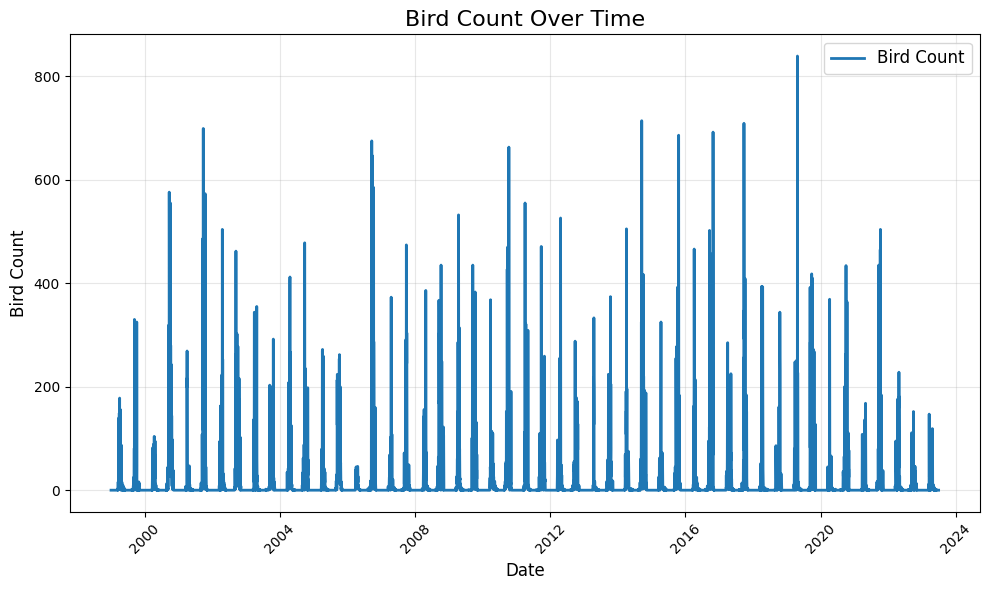

In [69]:
# Let's check out birds behaveour
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Plot a time series
plt.figure(figsize=(10, 6))
plt.plot(data['timestamp'], data['count'], linestyle='-', linewidth=2, label='Bird Count')
plt.title('Bird Count Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Bird Count', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


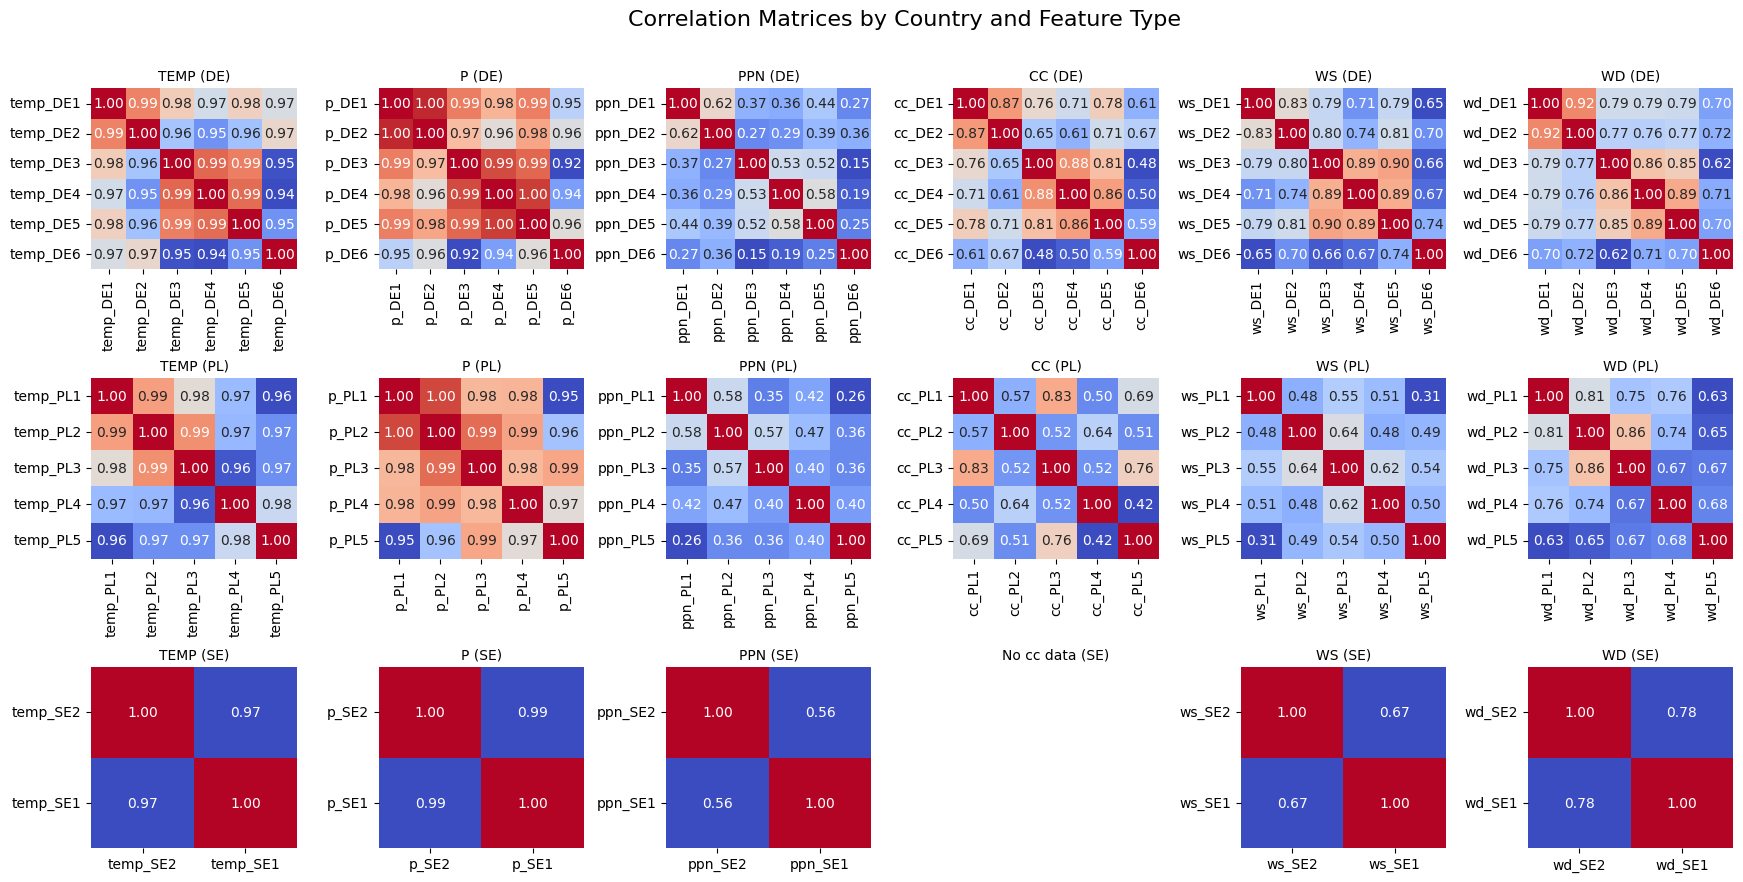

In [70]:
# Define countries and their respective stations
country_stations = {
    'DE': [col for col in data.columns if col.startswith('temp_DE') or col.startswith('p_DE') or col.startswith('ppn_DE') or col.startswith('cc_DE') or col.startswith('ws_DE') or col.startswith('wd_DE')],
    'PL': [col for col in data.columns if col.startswith('temp_PL') or col.startswith('p_PL') or col.startswith('ppn_PL') or col.startswith('cc_PL') or col.startswith('ws_PL') or col.startswith('wd_PL')],
    'DK': [col for col in data.columns if col.startswith('temp_DK') or col.startswith('p_DK') or col.startswith('ppn_DK') or col.startswith('cc_DK') or col.startswith('ws_DK') or col.startswith('wd_DK')],
    'SE': [col for col in data.columns if col.startswith('temp_SE') or col.startswith('p_SE') or col.startswith('ppn_SE') or col.startswith('cc_SE') or col.startswith('ws_SE') or col.startswith('wd_SE')],
    'LV': [col for col in data.columns if col.startswith('temp_LV') or col.startswith('p_LV') or col.startswith('ppn_LV') or col.startswith('cc_LV') or col.startswith('ws_LV') or col.startswith('wd_LV')]
}

# Function to calculate and plot the correlation matrix for a country's feature
def analyze_country_redundancy(data, country_code, feature_type, ax):
    features = [col for col in country_stations[country_code] if col.startswith(f"{feature_type}_")]
    if len(features) > 1:
        corr_matrix = data[features].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=ax, cbar=False)
        ax.set_title(f"{feature_type.upper()} ({country_code})", fontsize=10)
        ax.tick_params(axis='y', rotation=0) 
    else:
        ax.axis('off') 
        ax.set_title(f"No {feature_type} data ({country_code})", fontsize=10)

features_per_row = 6
feature_types = ['temp', 'p', 'ppn', 'cc', 'ws', 'wd']

# Create subplots
num_rows = len(country_stations) - 2  # Exclude LV and DK
fig, axes = plt.subplots(num_rows, features_per_row, figsize=(18, num_rows * 3))
fig.tight_layout(pad=4) 

row_idx = 0 
for country in country_stations.keys():
    if country in ['LV', 'DK']:
        continue
    for col_idx, feature_type in enumerate(feature_types):
        ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
        analyze_country_redundancy(data, country, feature_type, ax)
    row_idx += 1 

plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.suptitle("Correlation Matrices by Country and Feature Type", fontsize=16, y=1.02)
plt.show()


In [71]:
# Cut columns
columns_to_keep = [
    "timestamp", 
    "temp_Oie", "p_Oie", "ppn_Oie",           "ws_Oie", "wd_Oie",
    "temp_DE1", "p_DE1", "ppn_DE1", "cc_DE1", "ws_DE1", "wd_DE1",
    "temp_PL1", "p_PL1", "ppn_PL1", "cc_PL1", "ws_PL1", "wd_PL1",
    "temp_DK",  "p_DK",                       "ws_DK",  "wd_DK",
    "temp_SE1", "p_SE1", "ppn_SE1",           "ws_SE1", "wd_SE1",
    "temp_LV",  "p_LV",  "ppn_LV",            "ws_LV",  "wd_LV",
    "year", "spring", "month_sin", "month_cos", "day_sin", "day_cos", 
    "day_of_year_sin", "day_of_year_cos", "ringing_season", "future_count"
]

# Filter the dataset
data = data[columns_to_keep]

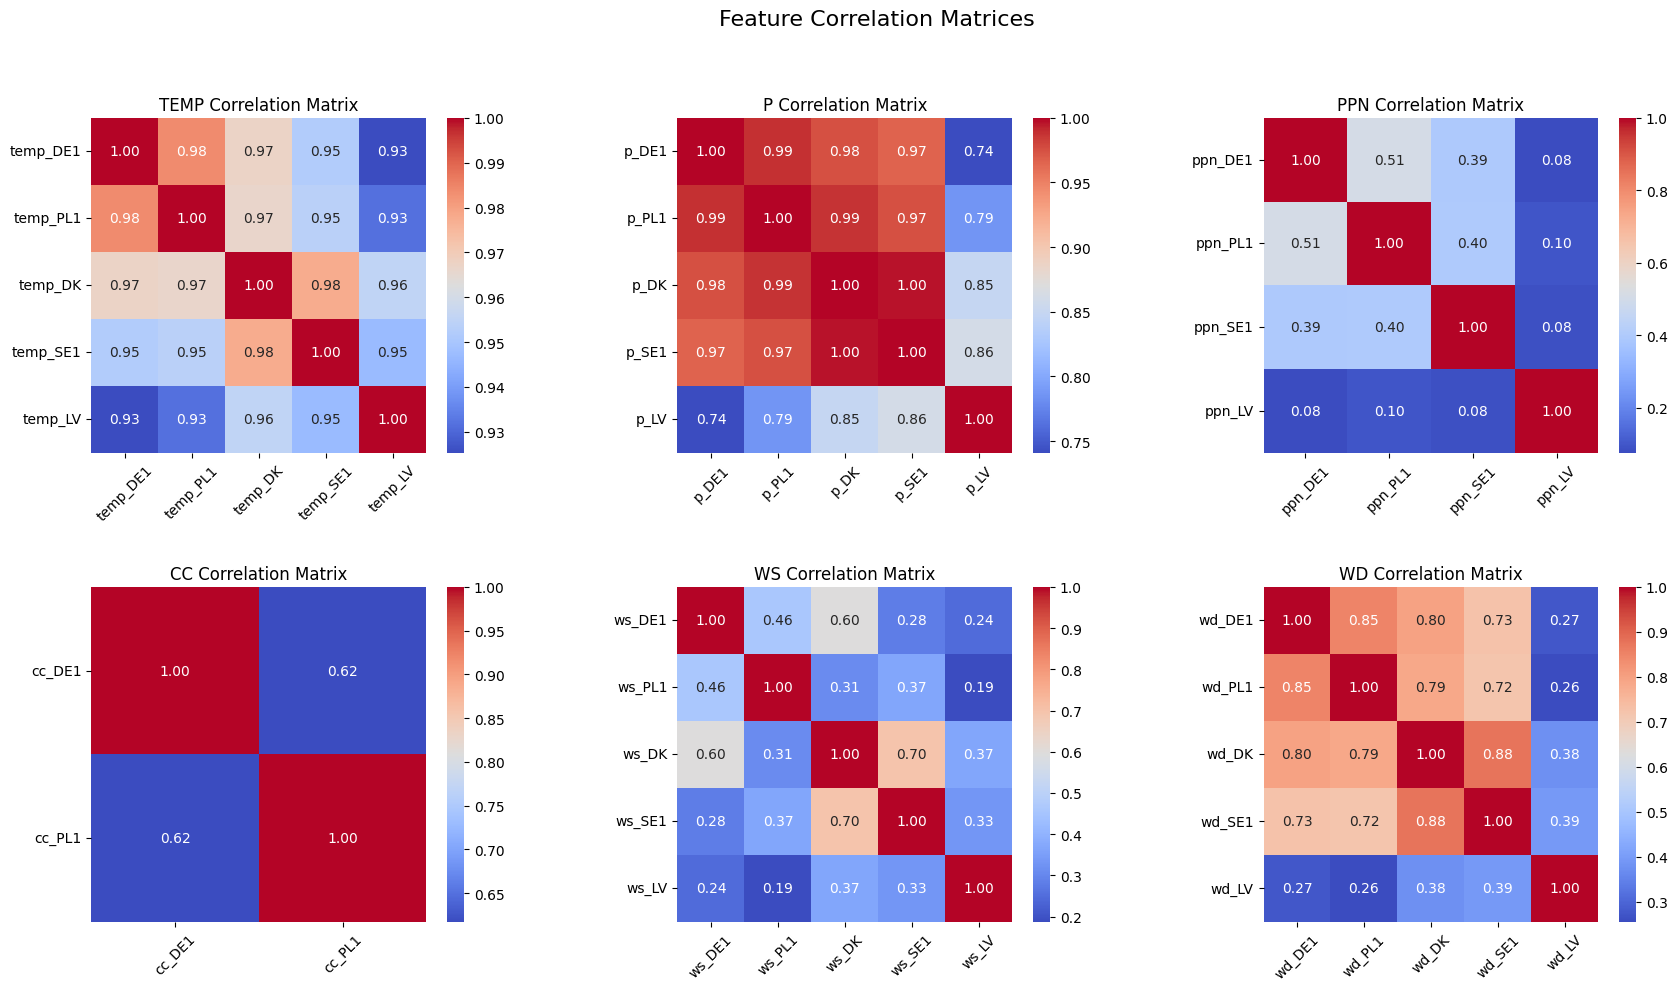

In [72]:
# Function to create and plot correlation matrix
def create_and_plot_correlation_matrix(ax, data, attribute_prefix, title):
    columns = [col for col in data.columns if col.startswith(attribute_prefix) and col.split("_")[1] != "Oie"]
    
    if len(columns) > 1:  # Only if there are > two columns
        correlation_matrix = data[columns].corr()
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, ax=ax)
        ax.set_title(title, fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)
    else:
        ax.axis('off') 
        ax.set_title(f"No data for {title}", fontsize=12)

feature_types = ['temp', 'p', 'ppn', 'cc', 'ws', 'wd']
fig, axes = plt.subplots(2, 3, figsize=(18, 10)) 
fig.tight_layout(pad=6)

for i, feature_type in enumerate(feature_types):
    row, col = divmod(i, 3) 
    ax = axes[row, col]
    create_and_plot_correlation_matrix(ax, data, f"{feature_type}_", f'{feature_type.upper()} Correlation Matrix')

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.suptitle("Feature Correlation Matrices", fontsize=16, y=1.02)
plt.show()

In [73]:
# Cut columns
columns_to_keep = [
    "timestamp", 
    "temp_Oie", "p_Oie", "ppn_Oie",           "ws_Oie", "wd_Oie",
    "temp_DE1", "p_DE1", "ppn_DE1", "cc_DE1", "ws_DE1", "wd_DE1",
    "year", "spring", "month_sin", "month_cos", "day_sin", "day_cos", 
    "day_of_year_sin", "day_of_year_cos", "ringing_season", "future_count"
]

# Filter the dataset
data = data[columns_to_keep]

In [74]:
# Cut columns
columns_to_keep = [
    "temp_Oie", "p_Oie", "ppn_Oie",           "ws_Oie", "wd_Oie",
    "temp_DE1", "p_DE1", "ppn_DE1", "cc_DE1", "ws_DE1", "wd_DE1",
    "spring", "month_sin", "month_cos", "day_sin", "day_cos",
    "future_count"
]

# Filter the dataset
data = data[columns_to_keep]

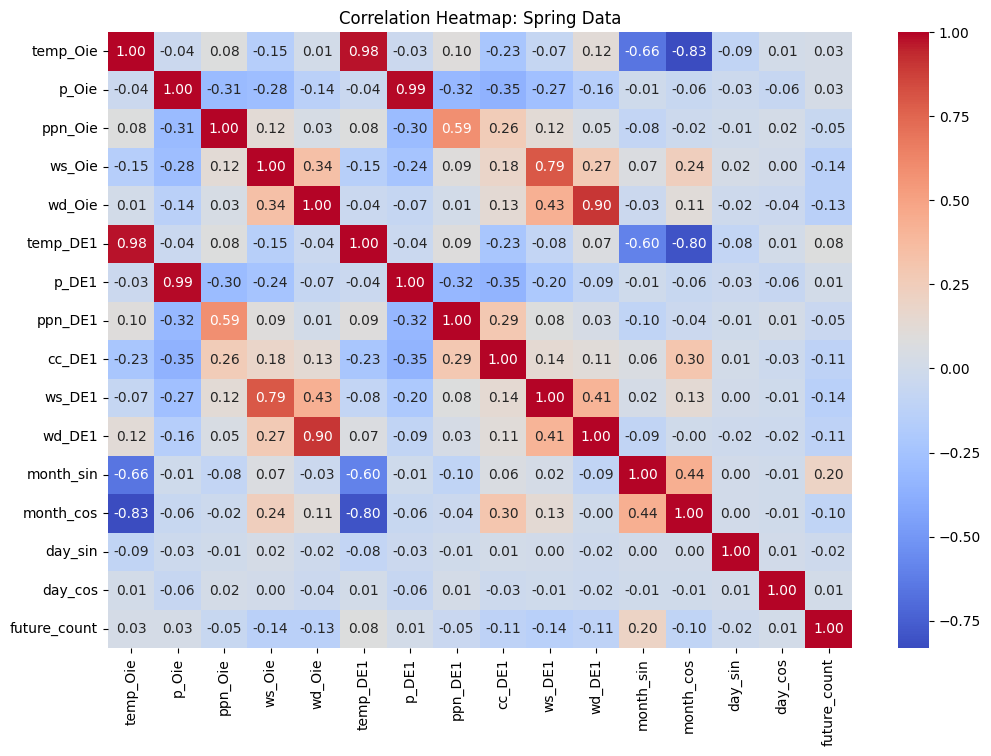

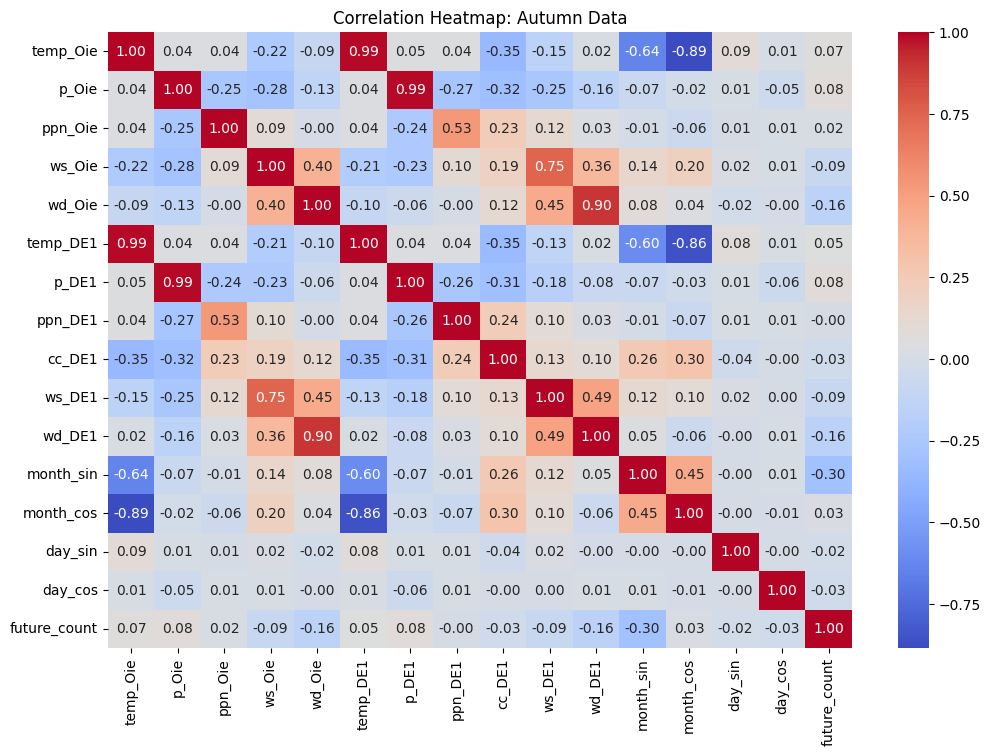

In [75]:
predictors = ['temp_Oie', 'p_Oie', 'ppn_Oie', 'ws_Oie', 'wd_Oie', 
              "temp_DE1", "p_DE1", "ppn_DE1", "cc_DE1", "ws_DE1", "wd_DE1",
              'month_sin', 'month_cos', 'day_sin', 'day_cos']
target = 'future_count'

# Spring and Autumn Filtering
spring_data = data[data['spring'] == 1].apply(pd.to_numeric, errors='coerce')
autumn_data = data[data['spring'] == 0].apply(pd.to_numeric, errors='coerce')

# Function to plot correlation heatmap
def plot_correlation_heatmap(data, title):
    plt.figure(figsize=(12, 8))
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(title)
    plt.show()

plot_correlation_heatmap(spring_data[predictors + [target]], "Correlation Heatmap: Spring Data")
plot_correlation_heatmap(autumn_data[predictors + [target]], "Correlation Heatmap: Autumn Data")

In [76]:
# Filter Relevant Columns for Predictive Modeling
predictors = ['temp_Oie', 'p_Oie', 'ppn_Oie', 'ws_Oie', 'wd_Oie', 
              "ppn_DE1", "cc_DE1",
              'month_sin', 'month_cos', 'day_sin', 'day_cos']
target = 'future_count'

# Spring and Autumn Filtering
spring_data = data[data['spring'] == 1].apply(pd.to_numeric, errors='coerce')
autumn_data = data[data['spring'] == 0].apply(pd.to_numeric, errors='coerce')

In [77]:
tf.random.set_seed(42)

#Function to Prepare Data for Modeling
def prepare_data(df, predictors, target):
    X = df[predictors]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [78]:
# Prepare Spring Data
X_train_spring, X_test_spring, y_train_spring, y_test_spring = prepare_data(spring_data, predictors, target)

# Prepare Autumn Data
X_train_autumn, X_test_autumn, y_train_autumn, y_test_autumn = prepare_data(autumn_data, predictors, target)

# Let's check if our training and test set are homogeneous with respect to the ranges of our target:
print(np.mean(y_train_autumn),'mean train aut',np.std(y_train_autumn),'std train aut')
print(np.mean(y_test_autumn),'mean test aut',np.std(y_test_autumn),'std test aut')
print(np.mean(y_train_spring),'mean train spr',np.std(y_train_spring),'std train spr')
print(np.mean(y_test_spring),'mean test spr',np.std(y_test_spring),'std test spr')

22.34626274065685 mean train aut 69.46827151758598 std train aut
24.19683257918552 mean test aut 73.56823218174769 std test aut
12.11644591611479 mean train spr 44.94564063993359 std train spr
12.666666666666666 mean test spr 47.49817393182588 std test spr


In [79]:
# Define data structures to collect data from all Models and analyze at the end
models_spring = [] # Models names
rmse_train_spring = []  # RMSE on training data
rmse_val_spring = []    # RMSE on validation data
r2_train_spring = []  # R² on training data
r2_val_spring = []    # R² on validation data

models_autumn = [] # Models names
rmse_train_autumn = []  # RMSE on training data
rmse_val_autumn = []    # RMSE on validation data
r2_train_autumn = []  # R² on training data
r2_val_autumn = []    # R² on validation data



In [80]:
def evaluate_model(name, models, model, X_train, X_test, y_train, y_test, rmse_train, r2_train, rmse_val, r2_val):
    models.append(name)
    nn_pred_train = model.predict(X_train)
    nn_pred_test = model.predict(X_test)
    print(f'\n{name} Model:')
    print(f"Predicted birds: {nn_pred_test[0:5]}")
    print(f"Real birds: {list(y_test[:5])}")
    print("RMSE:", np.sqrt(mean_squared_error(y_test, nn_pred_test)))
    print("R^2:", r2_score(y_test, nn_pred_test))
    
    rmse_train.append(np.sqrt(mean_squared_error(y_train, nn_pred_train)).item())
    r2_train.append(r2_score(y_train, nn_pred_train))
    rmse_val.append(np.sqrt(mean_squared_error(y_test, nn_pred_test)).item())
    r2_val.append(r2_score(y_test, nn_pred_test))

In [81]:
# Benchmark Model: Linear Regression

# Spring Linear Model
lin_reg_spring = LinearRegression()
lin_reg_spring.fit(X_train_spring, y_train_spring)
evaluate_model("Linear Spring", models_spring, lin_reg_spring, 
                  X_train_spring, X_test_spring, y_train_spring, y_test_spring, 
                  rmse_train_spring, r2_train_spring, rmse_val_spring, r2_val_spring)

# Autumn Linear Model
lin_reg_autumn = LinearRegression()
lin_reg_autumn.fit(X_train_autumn, y_train_autumn)
evaluate_model("Linear Autumn", models_autumn, lin_reg_autumn, 
                  X_train_autumn, X_test_autumn, y_train_autumn, y_test_autumn, 
                  rmse_train_autumn, r2_train_autumn, rmse_val_autumn, r2_val_autumn)


Linear Spring Model:
Predicted birds: [18.36259618 -4.68706489 38.92000879  3.54662476 24.1798041 ]
Real birds: [0.0, 0.0, 532.0, 0.0, 1.0]
RMSE: 44.90490852218412
R^2: 0.10621347042956208

Linear Autumn Model:
Predicted birds: [-13.26288329 -15.20213522  53.1060067  -15.77678537   4.29040001]
Real birds: [0.0, 0.0, 292.0, 0.0, 0.0]
RMSE: 68.70822887318644
R^2: 0.12775825714152733


In [82]:
# Neural Network Model 1

def build_nn_model(input_dim, l1l2=None, l2l3=None, learning_rate=0.005):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu', kernel_regularizer=l1l2),
        Dense(32, activation='relu', kernel_regularizer=l2l3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def fit_nn_model(nn, X_train, y_train, X_test, y_test, callback):
    return nn.fit(
    X_train, y_train,
    epochs=100,
    batch_size=30,
    validation_data=(X_test, y_test),
    callbacks=[callback],
    verbose=0
)

def plot_fit_history(history_spring, history_autumn):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].plot(history_spring.history['loss'], label='Train Loss')
    ax[0].plot(history_spring.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Spring Neural Network Training History')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    ax[1].plot(history_autumn.history['loss'], label='Train Loss')
    ax[1].plot(history_autumn.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Autumn Neural Network Training History')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

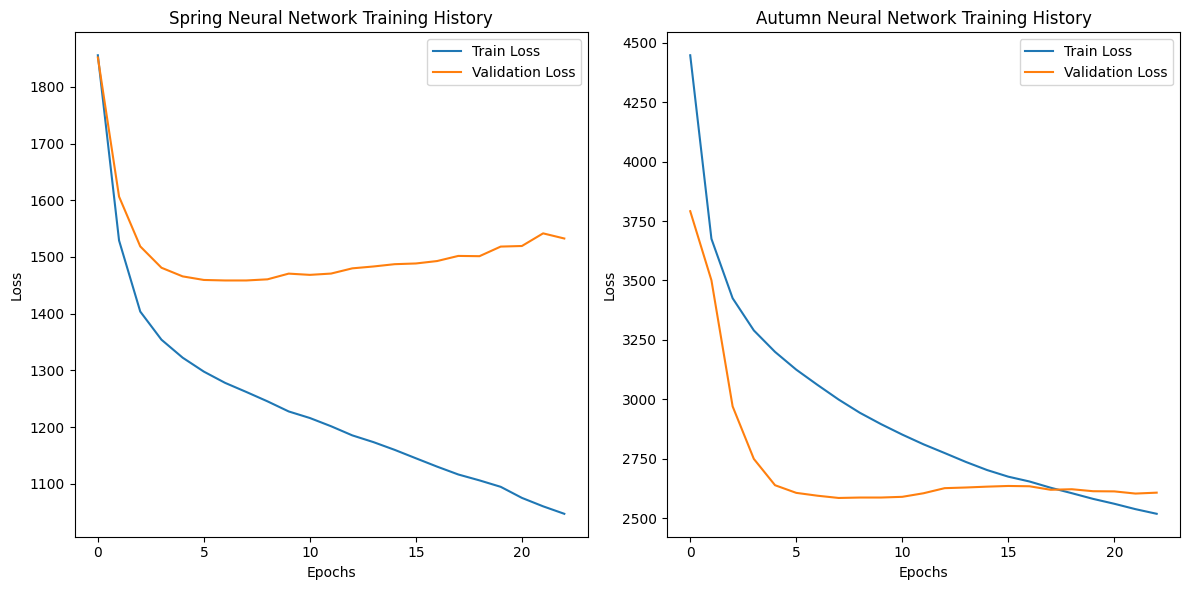

In [83]:
# Spring and Autumn Neural Network
nn_spring = build_nn_model(X_train_spring.shape[1])
nn_autumn = build_nn_model(X_train_autumn.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history_spring = fit_nn_model(nn_spring, X_train_spring, y_train_spring, X_test_spring, y_test_spring, early_stop)
history_autumn = fit_nn_model(nn_autumn, X_train_autumn, y_train_autumn, X_test_spring, y_test_spring, early_stop)

plot_fit_history(history_spring, history_autumn)

In [84]:
evaluate_model("NN Spring 1.0", models_spring, nn_spring, 
                  X_train_spring, X_test_spring, y_train_spring, y_test_spring, 
                  rmse_train_spring, r2_train_spring, rmse_val_spring, r2_val_spring)

evaluate_model("NN Autumn 1.0", models_autumn, nn_autumn, 
                  X_train_autumn, X_test_autumn, y_train_autumn, y_test_autumn, 
                  rmse_train_autumn, r2_train_autumn, rmse_val_autumn, r2_val_autumn)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

NN Spring 1.0 Model:
Predicted birds: [[ -0.20764598]
 [ -1.008325  ]
 [126.30736   ]
 [ -0.43243352]
 [ 62.890556  ]]
Real birds: [0.0, 0.0, 532.0, 0.0, 1.0]
RMSE: 38.19117819026986
R^2: 0.35349440757123807
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

NN Autumn 1.0 Model:
Predicted birds: [[-0.32263088]
 [-1.6287146 ]
 [16.387318  ]
 [-0.40923977]
 [-2.2985106 ]]
Real birds: [0.0, 0.0, 292.0, 0.0, 0.0]
RMSE: 59.25251319229483
R^2: 0.3513164110544954


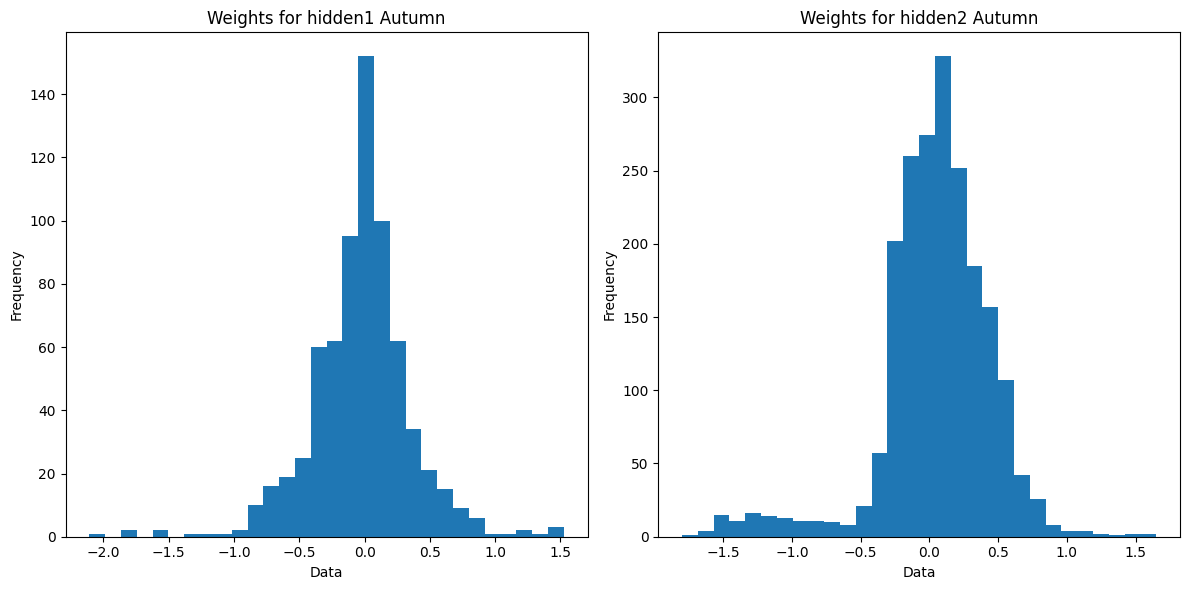

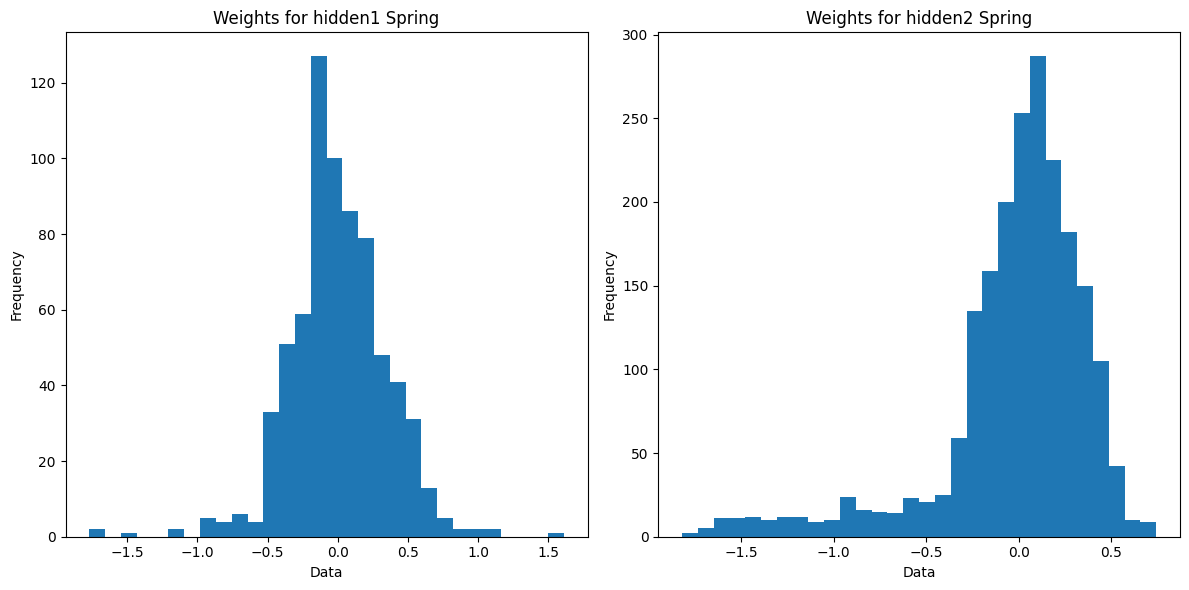

In [85]:
# Get Weights from hidden layers
hidden1, hidden2 = nn_autumn.layers[0], nn_autumn.layers[1]
weights1, biases1 = hidden1.get_weights()
weights2, biases2 = hidden2.get_weights()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(np.ndarray.flatten(weights1), density=False, bins=30)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Data')
ax[0].set_title('Weights for hidden1 Autumn')

ax[1].hist(np.ndarray.flatten(weights2), density=False, bins=30)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Data')
ax[1].set_title('Weights for hidden2 Autumn')

plt.tight_layout()
plt.show()

hidden1, hidden2 = nn_spring.layers[0], nn_spring.layers[1]
weights1, biases1 = hidden1.get_weights()
weights2, biases2 = hidden2.get_weights()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(np.ndarray.flatten(weights1), density=False, bins=30)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Data')
ax[0].set_title('Weights for hidden1 Spring')

ax[1].hist(np.ndarray.flatten(weights2), density=False, bins=30)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Data')
ax[1].set_title('Weights for hidden2 Spring')

plt.tight_layout()
plt.show()

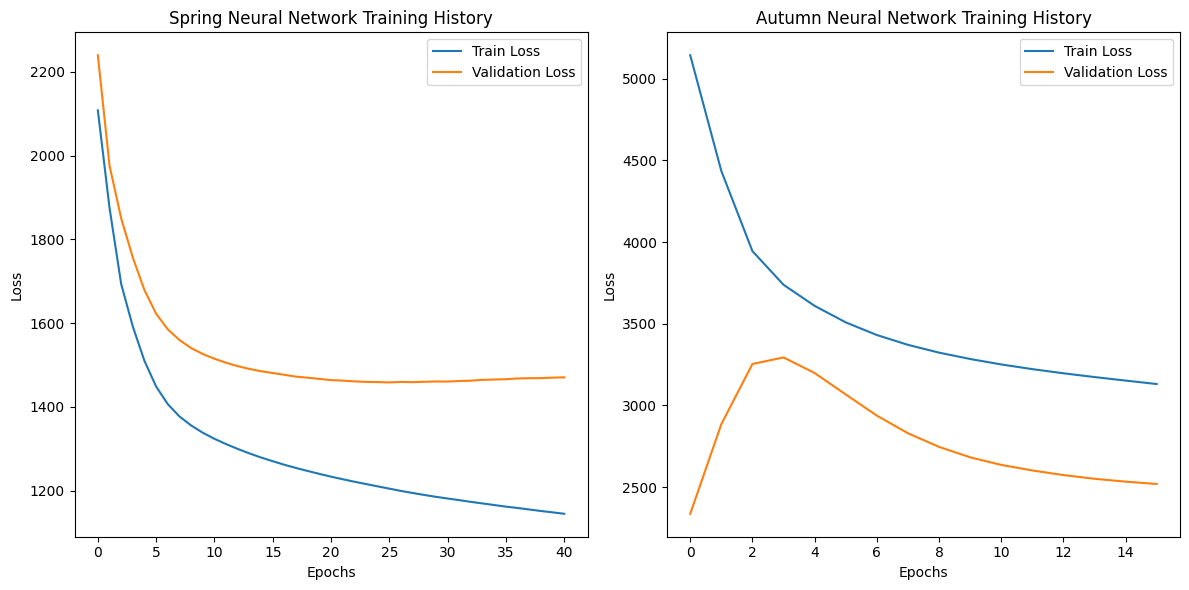

In [86]:
l1_l2=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001) 
l2_l3=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001) 

nn_spring = build_nn_model(X_train_spring.shape[1], l1_l2, l2_l3, learning_rate=0.001)
nn_autumn = build_nn_model(X_train_autumn.shape[1], l1_l2, l2_l3, learning_rate=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history_spring = fit_nn_model(nn_spring, X_train_spring, y_train_spring, X_test_spring, y_test_spring, early_stop)
history_autumn = fit_nn_model(nn_autumn, X_train_autumn, y_train_autumn, X_test_spring, y_test_spring, early_stop)

plot_fit_history(history_spring, history_autumn)

In [87]:
evaluate_model("NN Spring 1.1", models_spring, nn_spring, 
                  X_train_spring, X_test_spring, y_train_spring, y_test_spring, 
                  rmse_train_spring, r2_train_spring, rmse_val_spring, r2_val_spring)

evaluate_model("NN Autumn 1.1", models_autumn, nn_autumn, 
                  X_train_autumn, X_test_autumn, y_train_autumn, y_test_autumn, 
                  rmse_train_autumn, r2_train_autumn, rmse_val_autumn, r2_val_autumn)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

NN Spring 1.1 Model:
Predicted birds: [[ -0.42086133]
 [ -0.4797221 ]
 [143.61998   ]
 [  0.18928233]
 [ 64.77226   ]]
Real birds: [0.0, 0.0, 532.0, 0.0, 1.0]
RMSE: 38.17318048141032
R^2: 0.3541035994484889
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

NN Autumn 1.1 Model:
Predicted birds: [[ 3.6835923]
 [ 5.9994545]
 [ 8.269225 ]
 [ 4.0643334]
 [12.520181 ]]
Real birds: [0.0, 0.0, 292.0, 0.0, 0.0]
RMSE: 73.92717370265619
R^2: -0.009781862449055101


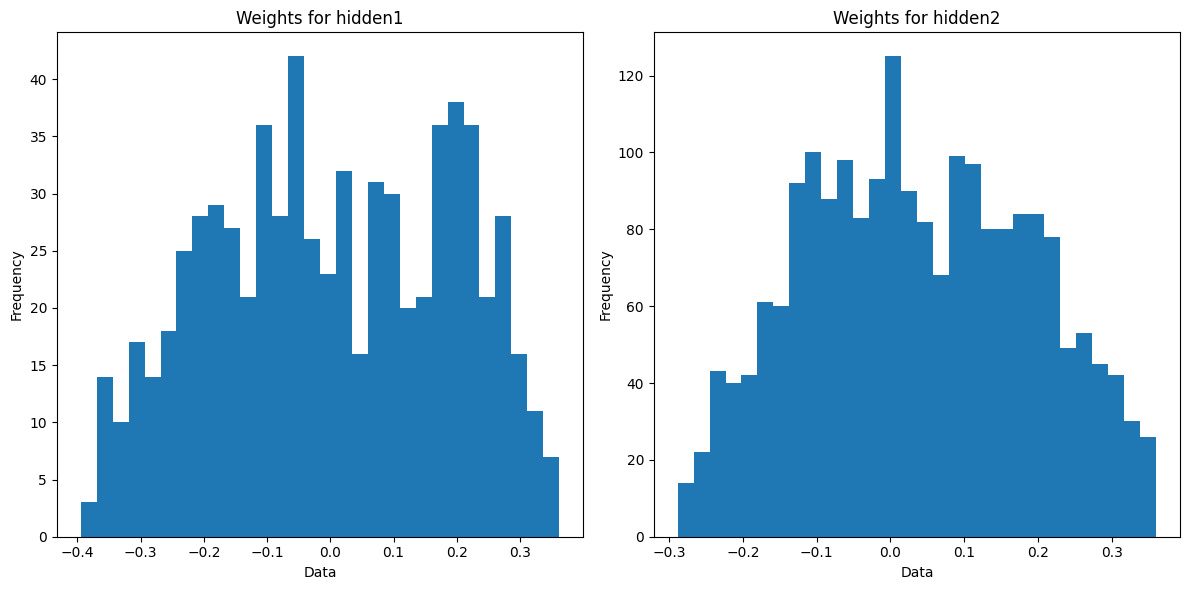

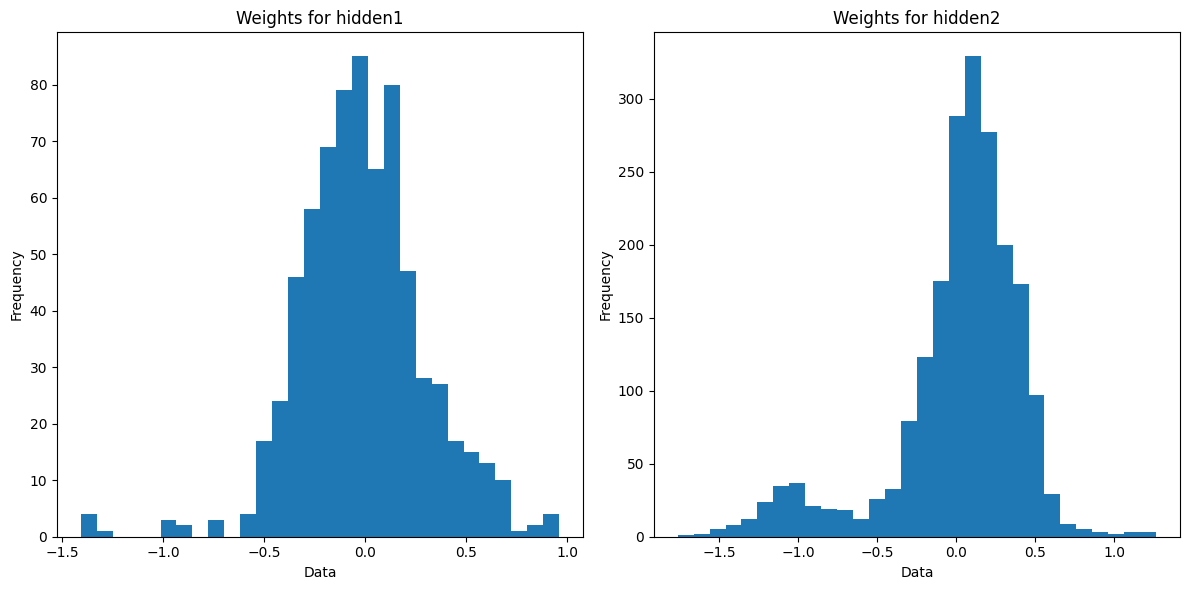

In [88]:
# Get Weights from hidden layers
hidden1, hidden2 = nn_autumn.layers[0], nn_autumn.layers[1]
weights1, biases1 = hidden1.get_weights()
weights2, biases2 = hidden2.get_weights()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(np.ndarray.flatten(weights1), density=False, bins=30)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Data')
ax[0].set_title('Weights for hidden1')

ax[1].hist(np.ndarray.flatten(weights2), density=False, bins=30)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Data')
ax[1].set_title('Weights for hidden2')

plt.tight_layout()
plt.show()

hidden1, hidden2 = nn_spring.layers[0], nn_spring.layers[1]
weights1, biases1 = hidden1.get_weights()
weights2, biases2 = hidden2.get_weights()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(np.ndarray.flatten(weights1), density=False, bins=30)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Data')
ax[0].set_title('Weights for hidden1')

ax[1].hist(np.ndarray.flatten(weights2), density=False, bins=30)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Data')
ax[1].set_title('Weights for hidden2')

plt.tight_layout()
plt.show()

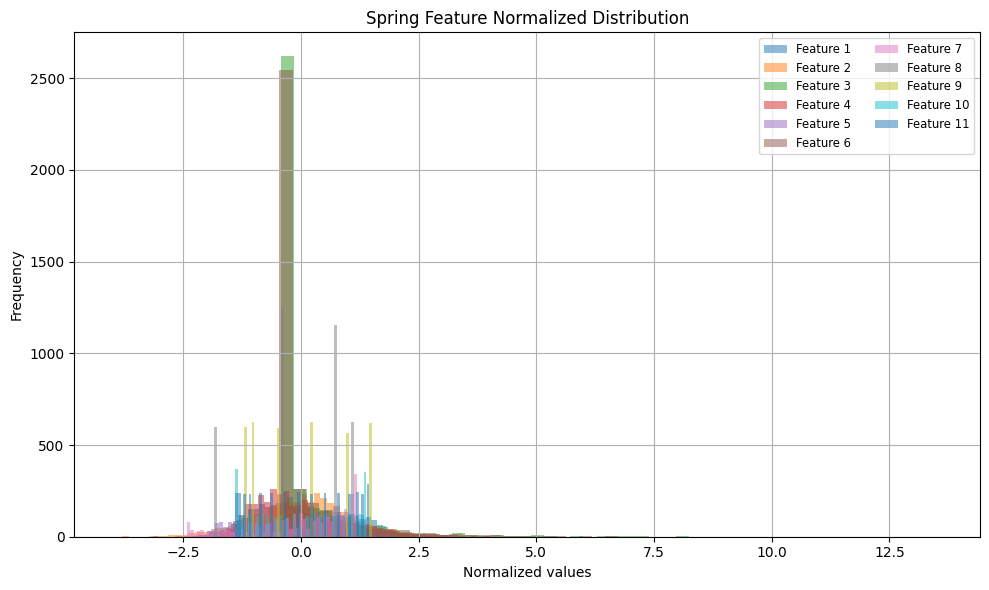

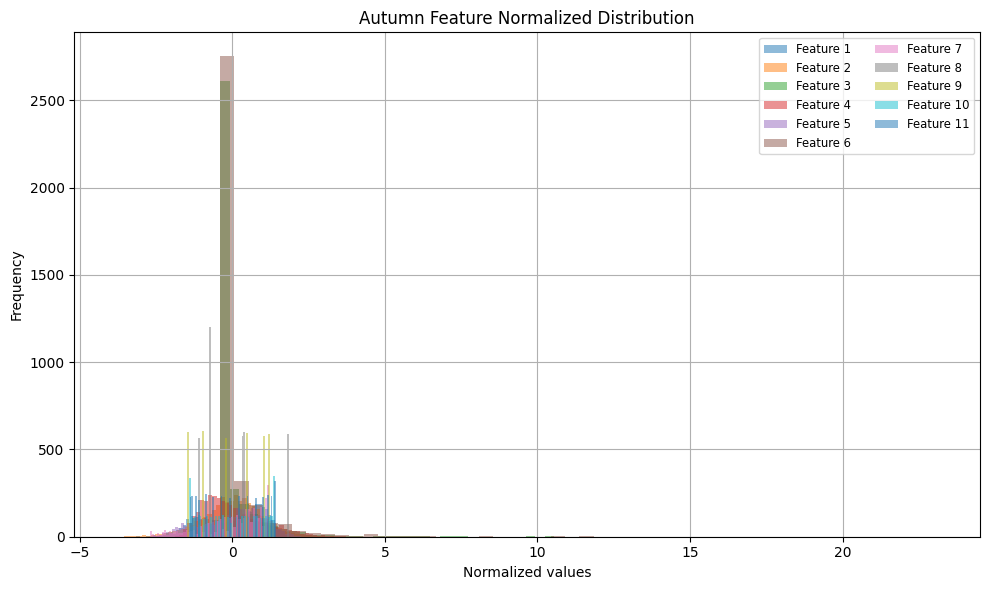

In [89]:
# Visualize distribution feature of x_train
plt.figure(figsize=(10, 6))
for i in range(X_train_spring.shape[1]):
    plt.hist(X_train_spring[:, i], bins=50, alpha=0.5, label=f'Feature {i+1}')

plt.title("Spring Feature Normalized Distribution")
plt.xlabel("Normalized values")
plt.ylabel("Frequency")
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(X_train_autumn.shape[1]):
    plt.hist(X_train_autumn[:, i], bins=50, alpha=0.5, label=f'Feature {i+1}')

plt.title("Autumn Feature Normalized Distribution")
plt.xlabel("Normalized values")
plt.ylabel("Frequency")
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [90]:
def build_nn_model(input_dim, l1l2=None, l2l3=None, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='tanh', kernel_regularizer=l1l2),
        Dense(32, activation='tanh', kernel_regularizer=l2l3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def fit_nn_model(nn, X_train, y_train, X_test, y_test, callback):
    return nn.fit(
    X_train, y_train,
    epochs=100,
    batch_size=30,
    validation_data=(X_test, y_test),
    callbacks=[callback],
    verbose=0
)

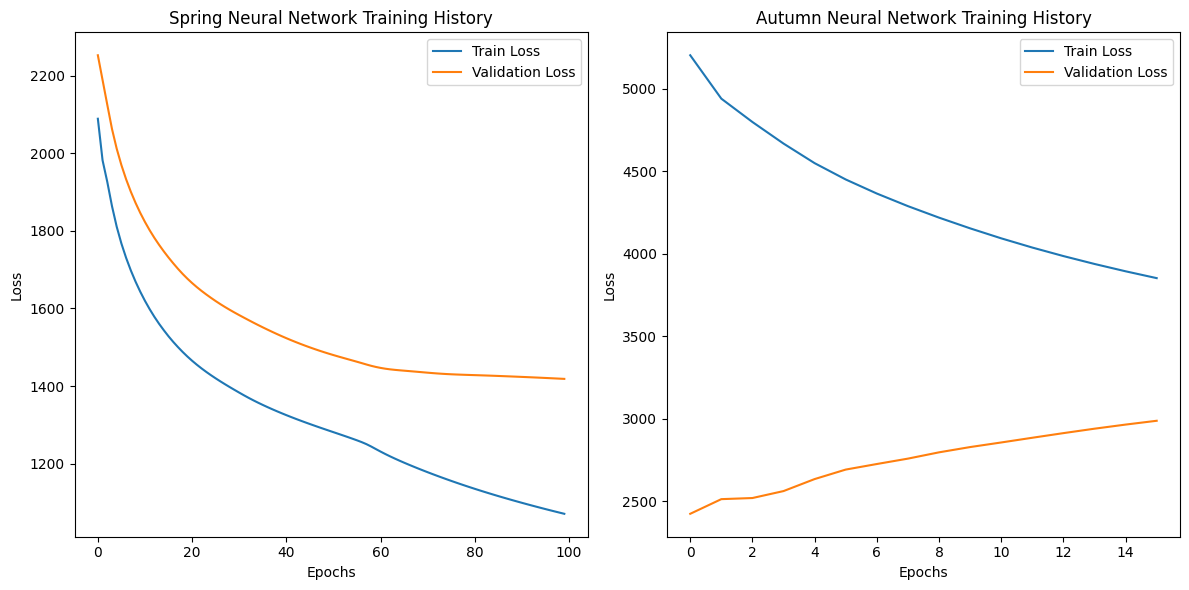

In [91]:
l1_l2=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)
l2_l3=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)

nn_spring = build_nn_model(X_train_spring.shape[1], l1_l2, l2_l3)
nn_autumn = build_nn_model(X_train_autumn.shape[1], l1_l2, l2_l3)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history_spring = fit_nn_model(nn_spring, X_train_spring, y_train_spring, X_test_spring, y_test_spring, early_stop)
history_autumn = fit_nn_model(nn_autumn, X_train_autumn, y_train_autumn, X_test_spring, y_test_spring, early_stop)

plot_fit_history(history_spring, history_autumn)

In [92]:
evaluate_model("NN Spring 2.0", models_spring, nn_spring, 
                  X_train_spring, X_test_spring, y_train_spring, y_test_spring, 
                  rmse_train_spring, r2_train_spring, rmse_val_spring, r2_val_spring)

evaluate_model("NN Autumn 2.0", models_autumn, nn_autumn, 
                  X_train_autumn, X_test_autumn, y_train_autumn, y_test_autumn, 
                  rmse_train_autumn, r2_train_autumn, rmse_val_autumn, r2_val_autumn)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

NN Spring 2.0 Model:
Predicted birds: [[  1.5507654]
 [  1.465388 ]
 [112.88901  ]
 [  1.5503236]
 [ 22.054518 ]]
Real birds: [0.0, 0.0, 532.0, 0.0, 1.0]
RMSE: 37.64408728324261
R^2: 0.3718842022783958
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

NN Autumn 2.0 Model:
Predicted birds: [[-6.581299 ]
 [-2.5402849]
 [ 6.2142577]
 [-6.008033 ]
 [ 4.450026 ]]
Real birds: [0.0, 0.0, 292.0, 0.0, 0.0]
RMSE: 75.46429530547098
R^2: -0.052209942890770966


In [93]:
def build_nn_model(input_dim, l1l2=None, l2l3=None, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='tanh', kernel_regularizer=l1l2),
        Dense(32, activation='tanh', kernel_regularizer=l2l3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model
    
def fit_nn_model(nn, X_train, y_train, X_test, y_test, callback):
    return nn.fit(
    X_train, y_train,
    shuffle=True,
    epochs=400,
    batch_size=90,
    validation_data=(X_test, y_test),
    callbacks=[callback],
    verbose=0)

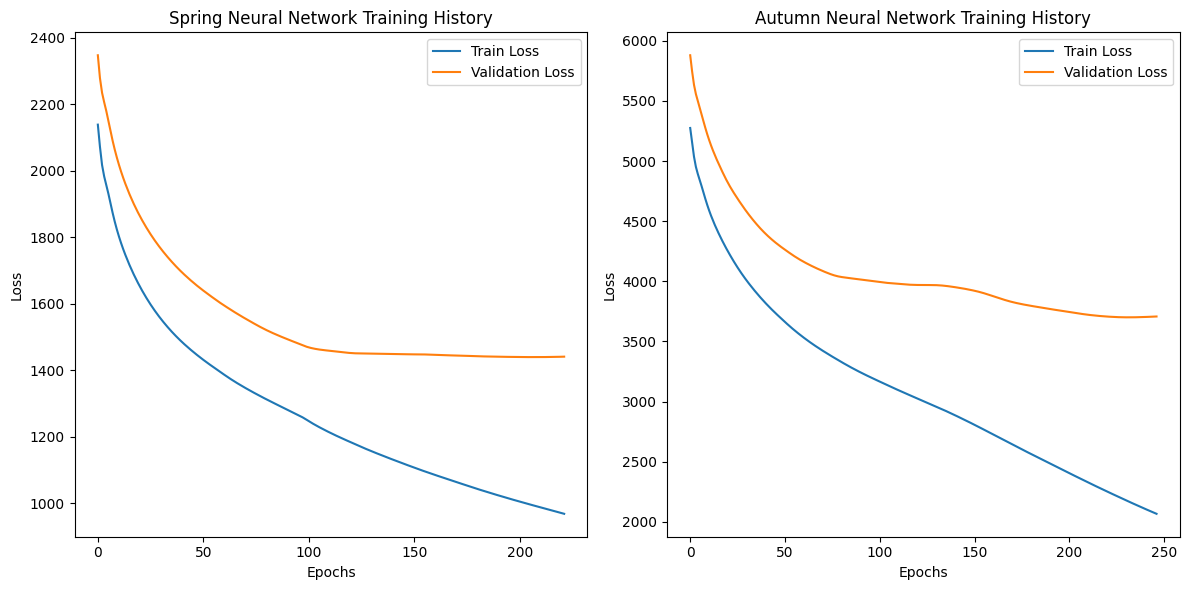

In [94]:
l1_l2=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001) # Lambda = 0.01
l2_l3=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001) # Lambda = 0.01

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # Increase our patience

nn_spring = build_nn_model(X_train_spring.shape[1], l1_l2, l2_l3)
nn_autumn = build_nn_model(X_train_autumn.shape[1], l1_l2, l2_l3)

history_spring = fit_nn_model(nn_spring, X_train_spring, y_train_spring, X_test_spring, y_test_spring, [early_stop])
history_autumn = fit_nn_model(nn_autumn, X_train_autumn, y_train_autumn, X_test_autumn, y_test_autumn, early_stop)

plot_fit_history(history_spring, history_autumn)

In [95]:
evaluate_model("NN Spring 2.1", models_spring, nn_spring, 
                  X_train_spring, X_test_spring, y_train_spring, y_test_spring, 
                  rmse_train_spring, r2_train_spring, rmse_val_spring, r2_val_spring)

evaluate_model("NN Autumn 2.1", models_autumn, nn_autumn, 
                  X_train_autumn, X_test_autumn, y_train_autumn, y_test_autumn, 
                  rmse_train_autumn, r2_train_autumn, rmse_val_autumn, r2_val_autumn)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

NN Spring 2.1 Model:
Predicted birds: [[  1.572835 ]
 [  1.5855999]
 [121.83175  ]
 [  1.577982 ]
 [ 48.300983 ]]
Real birds: [0.0, 0.0, 532.0, 0.0, 1.0]
RMSE: 37.92541308869982
R^2: 0.3624609179584516
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

NN Autumn 2.1 Model:
Predicted birds: [[2.2904985]
 [4.3336897]
 [8.279355 ]
 [1.87514  ]
 [4.3329773]]
Real birds: [0.0, 0.0, 292.0, 0.0, 0.0]
RMSE: 60.82009043722951
R^2: 0.31653940122964375


In [96]:
#Define Callback to log activations

class ActivationLogger(tf.keras.callbacks.Callback):
    def __init__(self, model, layer_name, data):
        self.mymodel = model
        self.layer_name = layer_name
        self.data = data
        self.epoch_activations = []

    def on_epoch_end(self, epoch, logs=None):
        layer_output = tf.keras.Model(
            inputs=self.mymodel.input,
            outputs=self.mymodel.get_layer(self.layer_name).output
        )
        activation_values = layer_output(self.data, training=False)
        self.epoch_activations.append(activation_values.numpy())

def NeuronsActivationReport(neurons_l1, neurons_l2, X_train, y_train, X_test, y_test):
    # Define regularizers
    l1_l2 = tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)
    l2_l3 = tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)
    
    # Define the model
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = tf.keras.layers.Dense(neurons_l1, activation='tanh', kernel_regularizer=l1_l2, name='dense1')(inputs)
    y = tf.keras.layers.Dense(neurons_l2, activation='tanh', kernel_regularizer=l2_l3, name='dense2')(x)
    outputs = tf.keras.layers.Dense(1)(y)
    NNRegModel = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    NNRegModel.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    
    # Prepare callbacks for activations
    activation_logger_dense1 = ActivationLogger(NNRegModel, layer_name='dense1', data=X_train)
    activation_logger_dense2 = ActivationLogger(NNRegModel, layer_name='dense2', data=X_train)
    
    # Explicitly call the model with a dummy input
    dummy_input = tf.random.normal((1, X_train.shape[1]))
    NNRegModel(dummy_input)
    
    # Fit the model
    NNRegModel.fit(
        X_train, y_train,
        shuffle=True,
        epochs=200,
        batch_size=90,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[activation_logger_dense1, activation_logger_dense2]
    )

    # Analyze activations for dense1
    all_epoch_activations_dense1 = np.array(activation_logger_dense1.epoch_activations)  # Shape: (epochs, samples, neurons)
    transposed_activations_dense1 = np.transpose(all_epoch_activations_dense1, (2, 0, 1))  # (neurons, epochs, samples)
    flattened_activations_dense1 = transposed_activations_dense1.reshape(transposed_activations_dense1.shape[0], -1)
    # Correlation for dense1
    correlation_matrix_dense1 = np.corrcoef(flattened_activations_dense1)
    
    # Analyze activations for dense2
    all_epoch_activations_dense2 = np.array(activation_logger_dense2.epoch_activations)  # Shape: (epochs, samples, neurons)
    transposed_activations_dense2 = np.transpose(all_epoch_activations_dense2, (2, 0, 1))  # (neurons, epochs, samples)
    flattened_activations_dense2 = transposed_activations_dense2.reshape(transposed_activations_dense2.shape[0], -1)
    # Correlation for dense2
    correlation_matrix_dense2 = np.corrcoef(flattened_activations_dense2)
    
    # Plot both correlation matrices in a single row
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Create a single row with two plots
    
    # Plot dense1 correlation matrix
    sns.heatmap(correlation_matrix_dense1, annot=False, cmap='coolwarm', ax=axes[0])
    axes[0].set_title('Neuron Activation Hidden 1')
    axes[0].set_xlabel('Neurons')
    axes[0].set_ylabel('Neurons')
    
    # Plot dense2 correlation matrix
    sns.heatmap(correlation_matrix_dense2, annot=False, cmap='coolwarm', ax=axes[1])
    axes[1].set_title('Neuron Activation Hidden 2')
    axes[1].set_xlabel('Neurons')
    axes[1].set_ylabel('Neurons')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

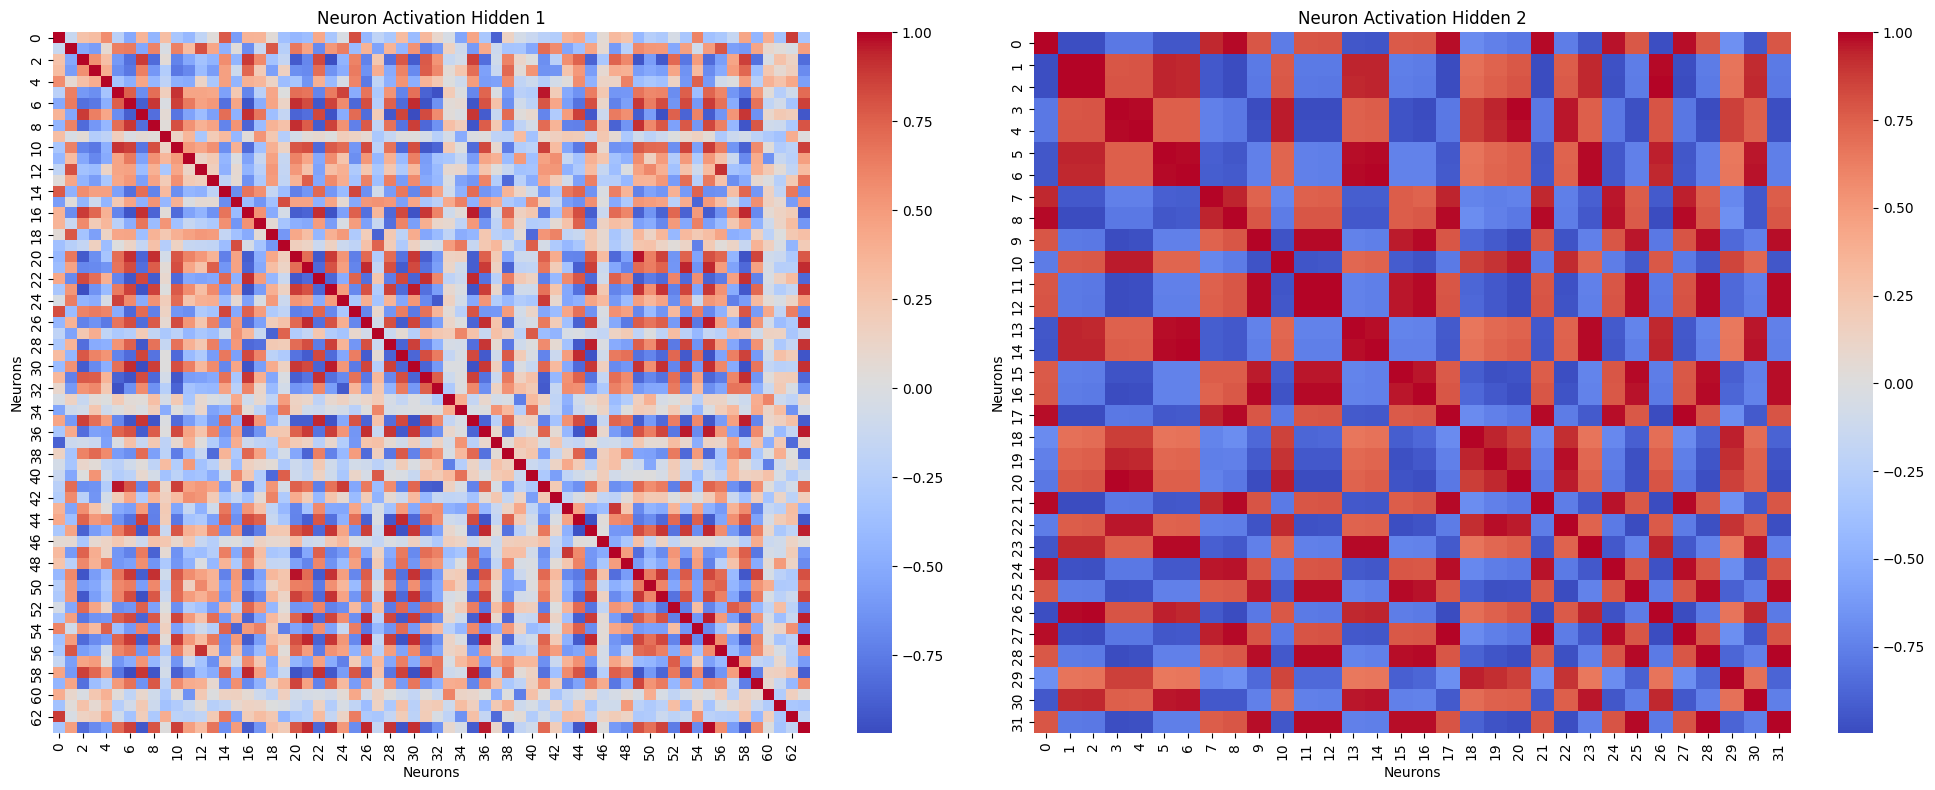

In [97]:
NeuronsActivationReport(64, 32, X_train_spring, y_train_spring, X_test_spring, y_test_spring)

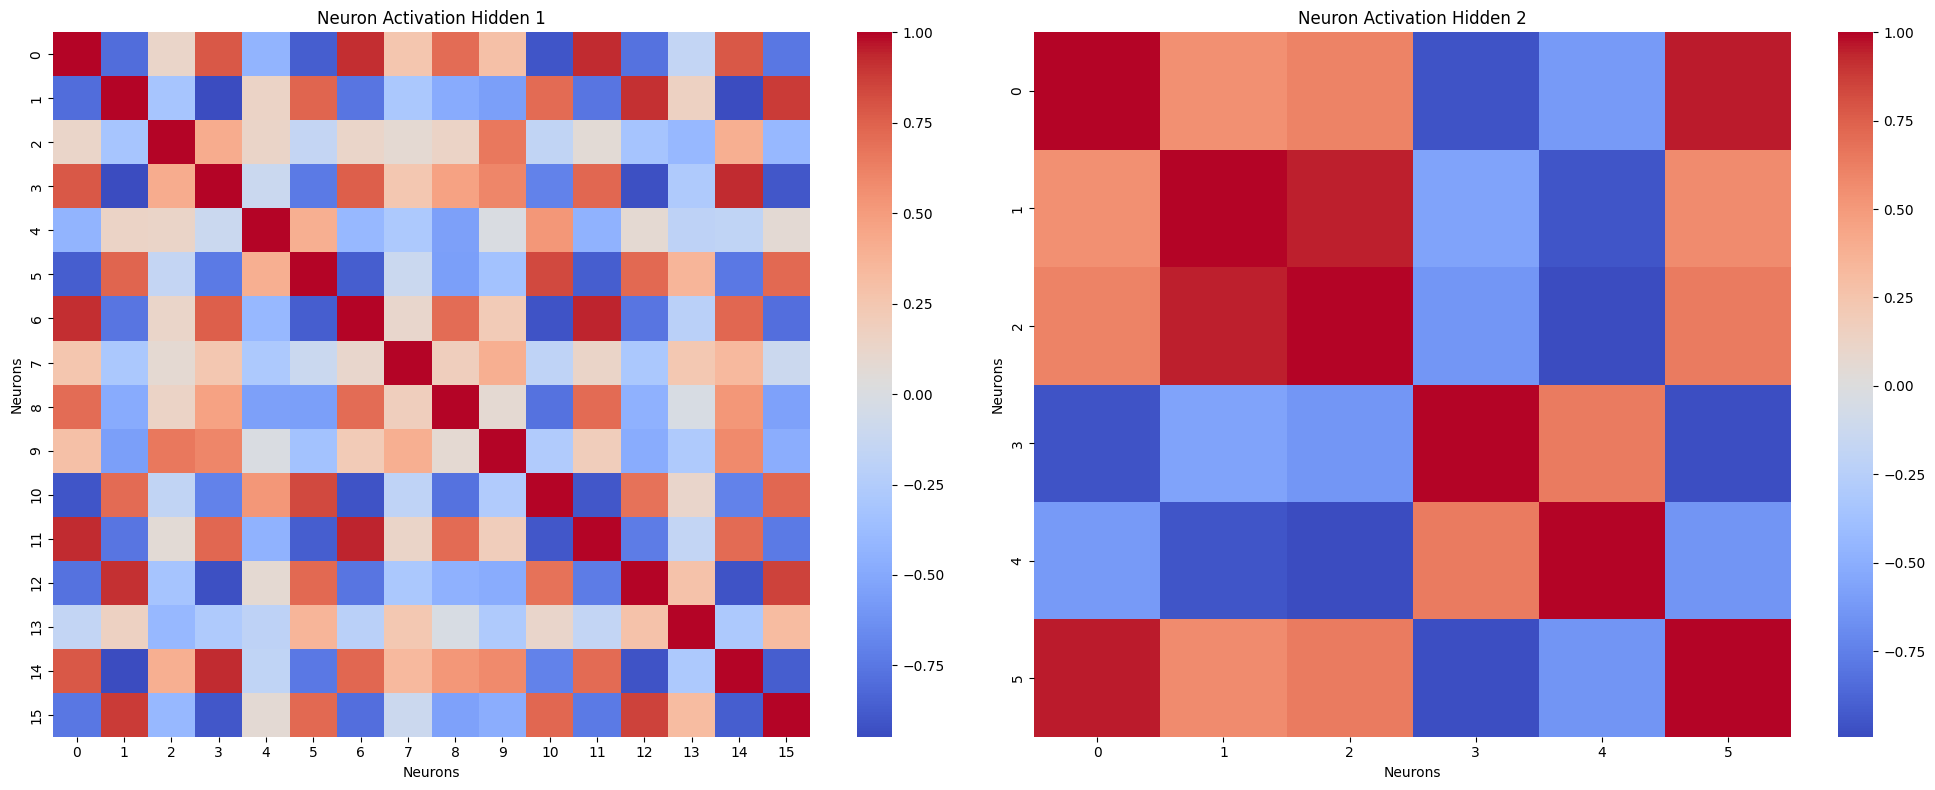

In [98]:
# Let's find a better solution, reducing number of neurons (if possible)
NeuronsActivationReport(16, 6, X_train_spring, y_train_spring, X_test_spring, y_test_spring)

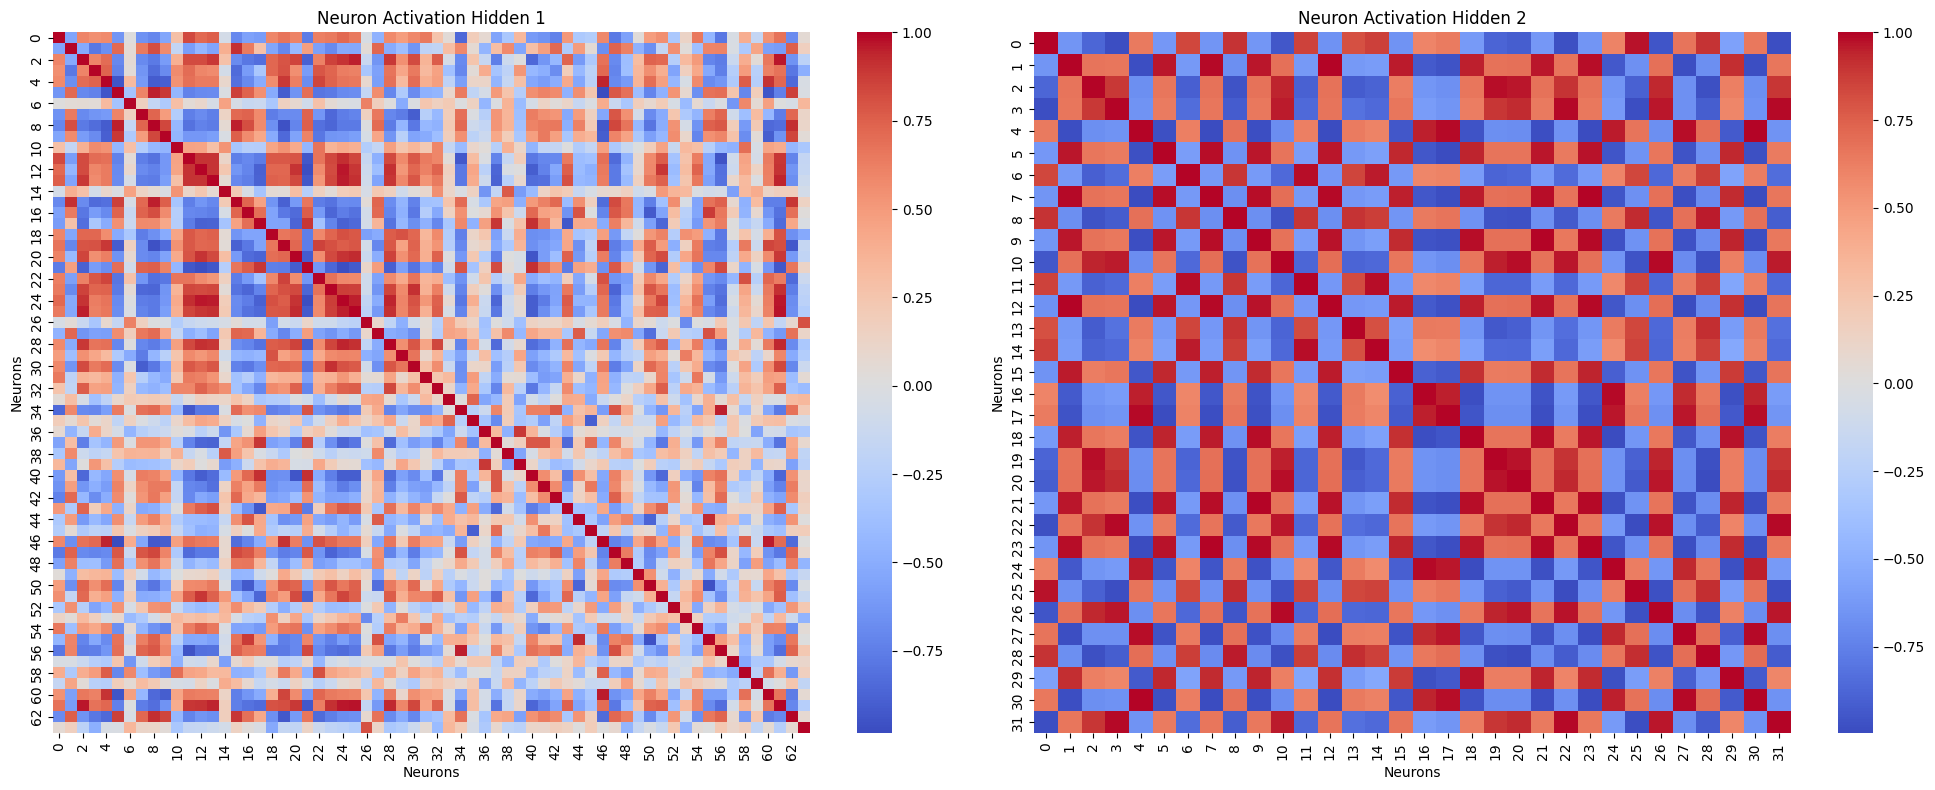

In [99]:
NeuronsActivationReport(64, 32, X_train_autumn, y_train_autumn, X_test_autumn, y_test_autumn)

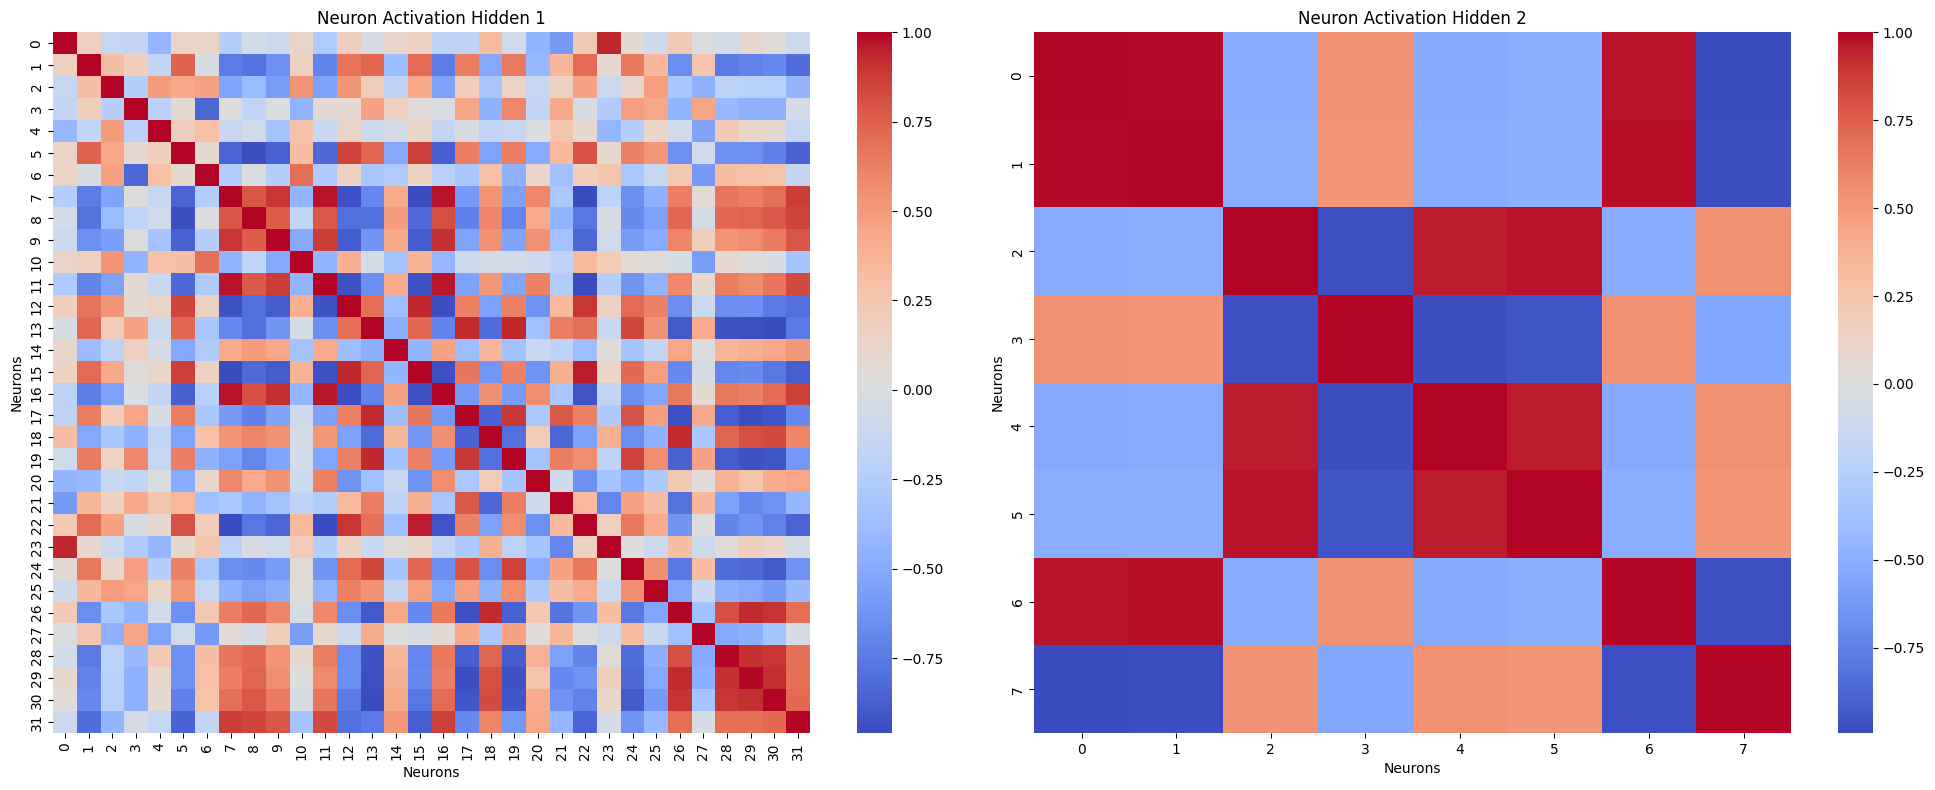

In [100]:
# Let's find a better solution, reducing number of neurons (if possible)
NeuronsActivationReport(32, 8, X_train_autumn, y_train_autumn, X_test_autumn, y_test_autumn)

In [101]:
def build_nn_model(input_dim, neurons_l1, neurons_l2, l1l2=None, l2l3=None, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(neurons_l1, activation='tanh', kernel_regularizer=l1l2),
        Dense(neurons_l2, activation='tanh', kernel_regularizer=l2l3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def fit_nn_model(nn, X_train, y_train, X_test, Y_test, callback):
    return nn.fit(
    X_train, y_train,
    shuffle=True,
    epochs=500,
    batch_size=100,
    callbacks=[callback],
    validation_data=(X_test, Y_test),
    verbose=0)

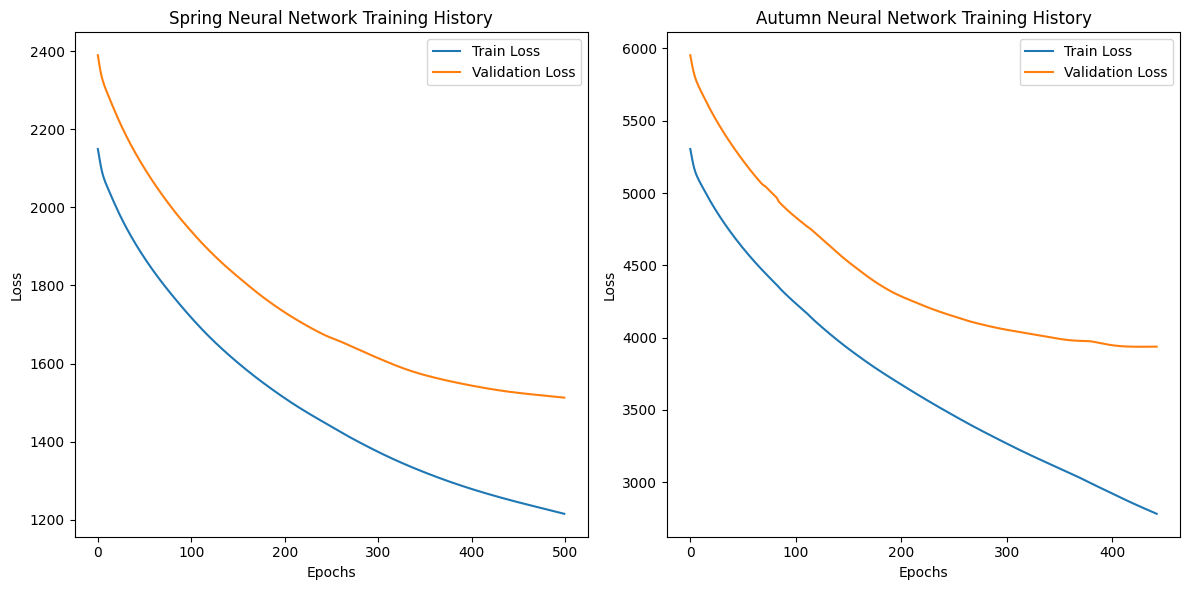

In [102]:
l1_l2=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001) # Lambda = 0.01
l2_l3=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001) # Lambda = 0.01

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

nn_spring = build_nn_model(X_train_spring.shape[1], 16, 6, l1_l2, l2_l3, learning_rate=0.001)
nn_autumn = build_nn_model(X_train_autumn.shape[1], 32, 8, l1_l2, l2_l3, learning_rate=0.001)

history_spring = fit_nn_model(nn_spring, X_train_spring, y_train_spring, X_test_spring, y_test_spring, [early_stop])
history_autumn = fit_nn_model(nn_autumn, X_train_autumn, y_train_autumn, X_test_autumn, y_test_autumn, early_stop)

plot_fit_history(history_spring, history_autumn)

In [103]:
evaluate_model("NN Spring 2.2", models_spring, nn_spring, 
                  X_train_spring, X_test_spring, y_train_spring, y_test_spring, 
                  rmse_train_spring, r2_train_spring, rmse_val_spring, r2_val_spring)

evaluate_model("NN Autumn 2.2", models_autumn, nn_autumn, 
                  X_train_autumn, X_test_autumn, y_train_autumn, y_test_autumn, 
                  rmse_train_autumn, r2_train_autumn, rmse_val_autumn, r2_val_autumn)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

NN Spring 2.2 Model:
Predicted birds: [[-1.0710545]
 [ 2.8470564]
 [84.19609  ]
 [ 0.6040869]
 [73.157265 ]]
Real birds: [0.0, 0.0, 532.0, 0.0, 1.0]
RMSE: 38.88989802005003
R^2: 0.3296219565228
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

NN Autumn 2.2 Model:
Predicted birds: [[-6.1285467]
 [ 4.1943846]
 [ 5.0514574]
 [-5.8750086]
 [ 4.2243843]]
Real birds: [0.0, 0.0, 292.0, 0.0, 0.0]
RMSE: 62.74178777682044
R^2: 0.27266725813071424


In [104]:
def build_nn_model(input_dim, neurons_l1, l1l2=None, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(neurons_l1, activation='tanh', kernel_regularizer=l1l2),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def fit_nn_model(nn, X_train, y_train, X_test, Y_test, callback):
    return nn.fit(
    X_train, y_train,
    shuffle=True,
    epochs=500,
    batch_size=90,
    callbacks=[callback],
    validation_data=(X_test, Y_test),
    verbose=0)

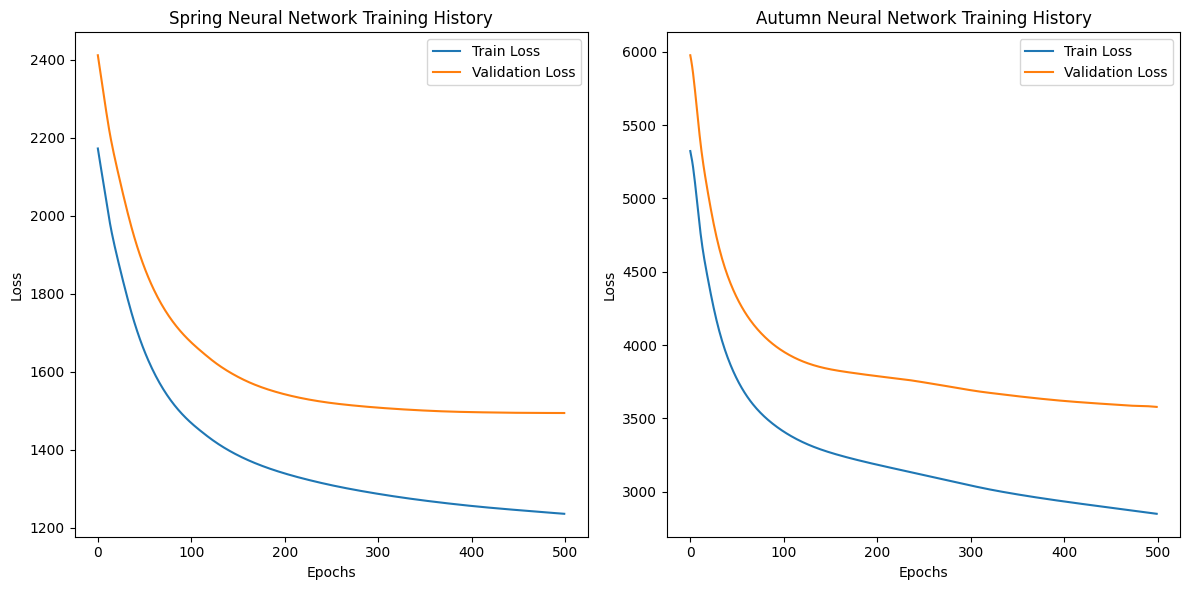

In [105]:
l1_l2=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001) # Lambda = 0.01
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # Increase our patience

nn_spring = build_nn_model(X_train_spring.shape[1], 16, l1_l2, learning_rate=0.001)
nn_autumn = build_nn_model(X_train_autumn.shape[1], 32, l1_l2, learning_rate=0.001)

history_spring = fit_nn_model(nn_spring, X_train_spring, y_train_spring, X_test_spring, y_test_spring, [early_stop])
history_autumn = fit_nn_model(nn_autumn, X_train_autumn, y_train_autumn, X_test_autumn, y_test_autumn, [early_stop])

plot_fit_history(history_spring, history_autumn)

In [106]:
evaluate_model("NN Spring 2.3", models_spring, nn_spring, 
                  X_train_spring, X_test_spring, y_train_spring, y_test_spring, 
                  rmse_train_spring, r2_train_spring, rmse_val_spring, r2_val_spring)

evaluate_model("NN Autumn 2.3", models_autumn, nn_autumn, 
                  X_train_autumn, X_test_autumn, y_train_autumn, y_test_autumn, 
                  rmse_train_autumn, r2_train_autumn, rmse_val_autumn, r2_val_autumn)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

NN Spring 2.3 Model:
Predicted birds: [[  0.7391058 ]
 [  0.92176974]
 [114.74999   ]
 [  0.7284943 ]
 [ 65.0619    ]]
Real birds: [0.0, 0.0, 532.0, 0.0, 1.0]
RMSE: 38.645326181814156
R^2: 0.3380272265060352
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

NN Autumn 2.3 Model:
Predicted birds: [[-0.47174358]
 [-2.6409664 ]
 [24.802362  ]
 [-0.46958256]
 [ 2.6197205 ]]
Real birds: [0.0, 0.0, 292.0, 0.0, 0.0]
RMSE: 59.812476712206276
R^2: 0.3389977594171454


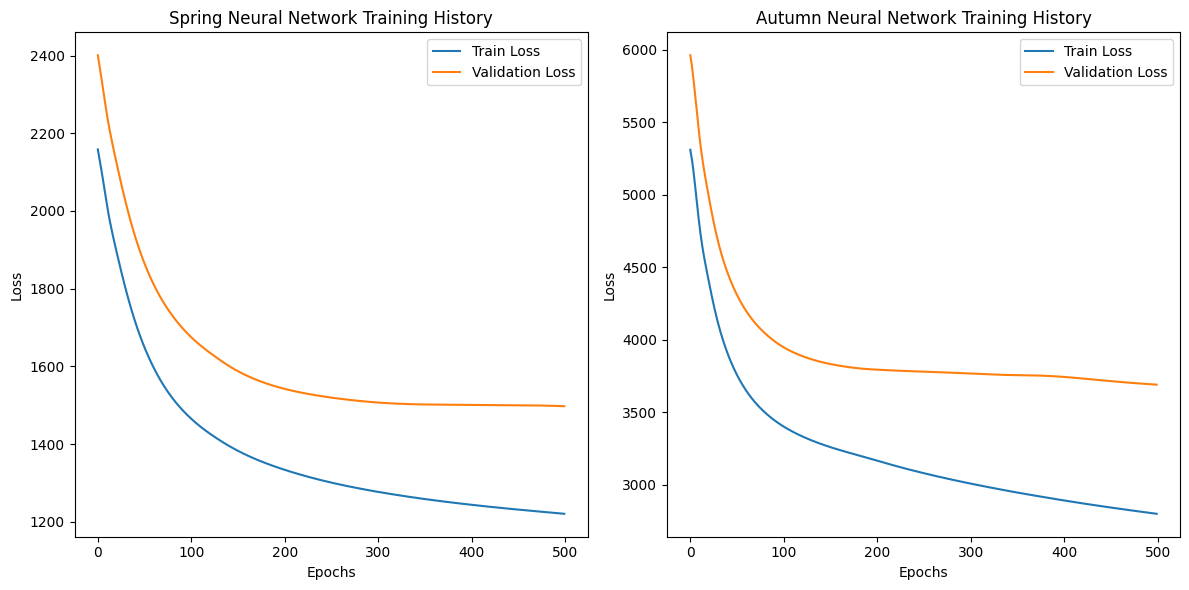

In [107]:
# Function to build the neural network model
def build_nn_model(input_dim, neurons_l1, l1l2=None, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(neurons_l1, activation='tanh', kernel_regularizer=l1l2),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Function to fit the neural network model
def fit_nn_model(nn, X_train, y_train, X_test, Y_test, callback):
    return nn.fit(
    X_train, y_train,
    shuffle=True,
    epochs=500,
    batch_size=90,
    callbacks=[callback],
    validation_data=(X_test, Y_test),
    verbose=0)

# Adding noise feature to training data
def add_noise_feature(X):
    np.random.seed(42)  # For reproducibility
    noise_feature = np.random.normal(loc=0, scale=1, size=(X.shape[0], 1))
    return np.hstack([X, noise_feature])

# Add noise feature to both spring and autumn datasets
X_train_spring_n = add_noise_feature(X_train_spring)
X_test_spring_n = add_noise_feature(X_test_spring)
X_train_autumn_n = add_noise_feature(X_train_autumn)
X_test_autumn_n = add_noise_feature(X_test_autumn)

l1_l2 = tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)  # Lambda = 0.01
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)  # Increase our patience

nn_spring = build_nn_model(X_train_spring_n.shape[1], 16, l1_l2, learning_rate=0.001)
nn_autumn = build_nn_model(X_train_autumn_n.shape[1], 32, l1_l2, learning_rate=0.001)

history_spring = fit_nn_model(nn_spring, X_train_spring_n, y_train_spring, X_test_spring_n, y_test_spring, [early_stop])
history_autumn = fit_nn_model(nn_autumn, X_train_autumn_n, y_train_autumn, X_test_autumn_n, y_test_autumn, [early_stop])

plot_fit_history(history_spring, history_autumn)

# Function to compute gradients for the entire dataset
def compute_dataset_sensitivity(model, X_dataset):
    all_gradients = []
    for sample in X_dataset:  # Iterate over each sample
        with tf.GradientTape() as tape:
            sample = tf.expand_dims(sample, axis=0)  # Add batch dimension
            tape.watch(sample)
            prediction = model(sample)
        gradients = tape.gradient(prediction, sample)
        all_gradients.append(gradients.numpy().flatten())  # Flatten to 1D
    return np.array(all_gradients)
    
# Convert the training data to a TensorFlow tensor
def featureImportance(X_train, model):
    X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
    
    # Calculate sensitivities
    all_sensitivities = compute_dataset_sensitivity(model, X_train_tensor)
    
    # Aggregate sensitivities (mean absolute value for each feature)
    mean_absolute_sensitivity = np.mean(np.abs(all_sensitivities), axis=0)
    
    # Aggregate sensitivities (mean value for each feature)
    mean_sensitivity = np.mean(all_sensitivities, axis=0)
    
    # Extract feature names from the DataFrame for plotting
    feature_names = data[predictors].columns.tolist()
    feature_names.append('Noise Feature')  # Add noise feature to feature names
    
    # Plot the average feature sensitivity
    plt.barh(feature_names, mean_absolute_sensitivity)
    plt.title("Average Feature Sensitivity (Training Set)")
    plt.xlabel("Mean Absolute Gradient")
    plt.ylabel("Features")
    plt.show()

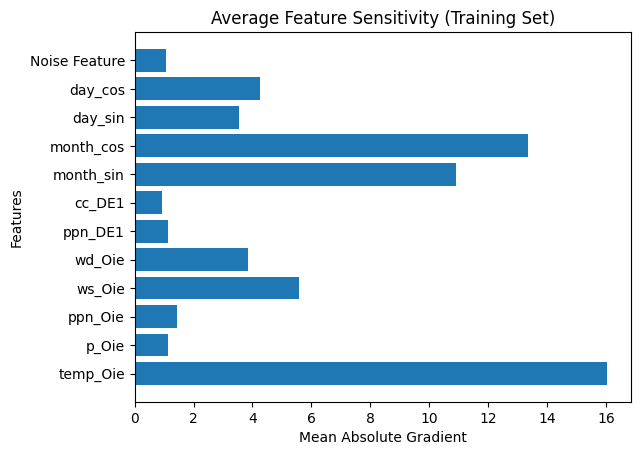

In [109]:
featureImportance(X_train_spring_n, nn_spring)

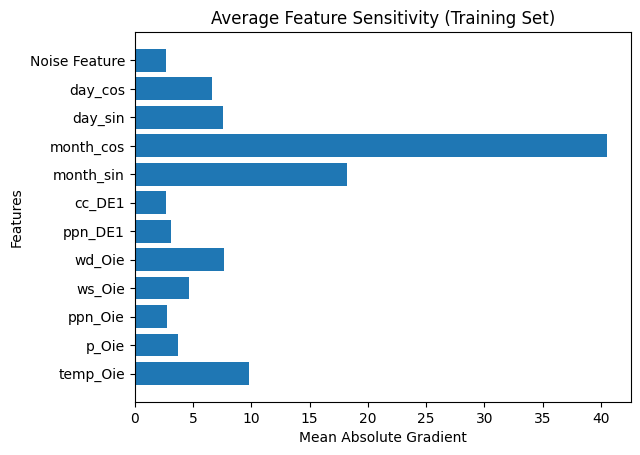

In [110]:
featureImportance(X_train_autumn_n, nn_autumn)

In [111]:
def build_nn_model(input_dim, neurons_l1, l1l2=None, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(neurons_l1, activation='tanh', kernel_regularizer=l1l2),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def fit_nn_model(nn, X_train, y_train, X_test, Y_test, callback):
    nn.fit(X_train, y_train,
    shuffle=True,
    epochs=500,
    batch_size=90,
    callbacks=[callback],
    validation_data=(X_test, Y_test),
    verbose=0)

l1_l2=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001) # Lambda = 0.01
l2_l3=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001) # Lambda = 0.01

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # Increase our patience

nn_spring = build_nn_model(X_train_spring.shape[1], 16, l1_l2)
nn_autumn = build_nn_model(X_train_autumn.shape[1], 32, l1_l2)

# create directory for models
from os import makedirs
makedirs('bm_models')

# fit and save models
n_members = 5
for i in range(n_members):
    # fit model
    model = build_nn_model(X_train_spring.shape[1], 16, l1_l2)
    fit_nn_model(model, X_train_spring, y_train_spring, X_test_spring, y_test_spring, [early_stop])
    # save model
    filename = 'bm_models/spr_model_' + str(i + 1) + '.keras'
    model.save(filename)
    print('>Saved %s' % filename)

for i in range(n_members):
    # fit model
    model = build_nn_model(X_train_autumn.shape[1], 32, l1_l2)
    fit_nn_model(model, X_train_autumn, y_train_autumn, X_test_autumn, y_test_autumn, [early_stop])
    # save model
    filename = 'bm_models/aut_model_' + str(i + 1) + '.keras'
    model.save(filename)
    print('>Saved %s' % filename)

>Saved bm_models/spr_model_1.keras
>Saved bm_models/spr_model_2.keras
>Saved bm_models/spr_model_3.keras
>Saved bm_models/spr_model_4.keras
>Saved bm_models/spr_model_5.keras
>Saved bm_models/aut_model_1.keras
>Saved bm_models/aut_model_2.keras
>Saved bm_models/aut_model_3.keras
>Saved bm_models/aut_model_4.keras
>Saved bm_models/aut_model_5.keras


In [112]:
# load models from file
def load_all_models(n_models, prefix):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = f'bm_models/{prefix}_model_' + str(i + 1) + '.keras'
        # load model from file
        model = tf.keras.models.load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

In [113]:
# load spr models
n_members = 5
spr_members = load_all_models(n_members, 'spr')
print('Loaded %d models' % len(spr_members))
# load aut models
aut_members = load_all_models(n_members, 'aut')
print('Loaded %d models' % len(aut_members))

>loaded bm_models/spr_model_1.keras
>loaded bm_models/spr_model_2.keras
>loaded bm_models/spr_model_3.keras
>loaded bm_models/spr_model_4.keras
>loaded bm_models/spr_model_5.keras
Loaded 5 models
>loaded bm_models/aut_model_1.keras
>loaded bm_models/aut_model_2.keras
>loaded bm_models/aut_model_3.keras
>loaded bm_models/aut_model_4.keras
>loaded bm_models/aut_model_5.keras
Loaded 5 models


In [114]:
spr_mse_train, spr_mse, spr_r2_train, spr_r2 = 0, 0, 0, 0
aut_mse_train, aut_mse, aut_r2_train, aut_r2 = 0, 0, 0, 0

for model in spr_members:
    nn_pred_train = model.predict(X_train_spring)
    nn_pred_test = model.predict(X_test_spring)
    spr_mse_train += np.sqrt(mean_squared_error(y_train_spring, nn_pred_train)).item()
    spr_r2_train += r2_score(y_train_spring, nn_pred_train)
    spr_mse += np.sqrt(mean_squared_error(y_test_spring, nn_pred_test)).item()
    spr_r2 += r2_score(y_test_spring, nn_pred_test)
for model in aut_members:
    nn_pred_train = model.predict(X_train_autumn)
    nn_pred_test = model.predict(X_test_autumn)
    aut_mse_train += np.sqrt(mean_squared_error(y_train_autumn, nn_pred_train)).item()
    aut_r2_train += r2_score(y_train_autumn, nn_pred_train)
    aut_mse += np.sqrt(mean_squared_error(y_test_autumn, nn_pred_test)).item()
    aut_r2 += r2_score(y_test_autumn, nn_pred_test)

models_spring.append("Ens NN 3.0")
rmse_train_spring.append(spr_mse_train / 5)
r2_train_spring.append(spr_r2_train / 5)
rmse_val_spring.append(spr_mse / 5)
r2_val_spring.append(spr_r2 / 5)

models_autumn.append("Ens NN 3.0")
rmse_train_autumn.append(aut_mse_train / 5)
r2_train_autumn.append(aut_r2_train / 5)
rmse_val_autumn.append(aut_mse / 5)
r2_val_autumn.append(aut_r2 / 5)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


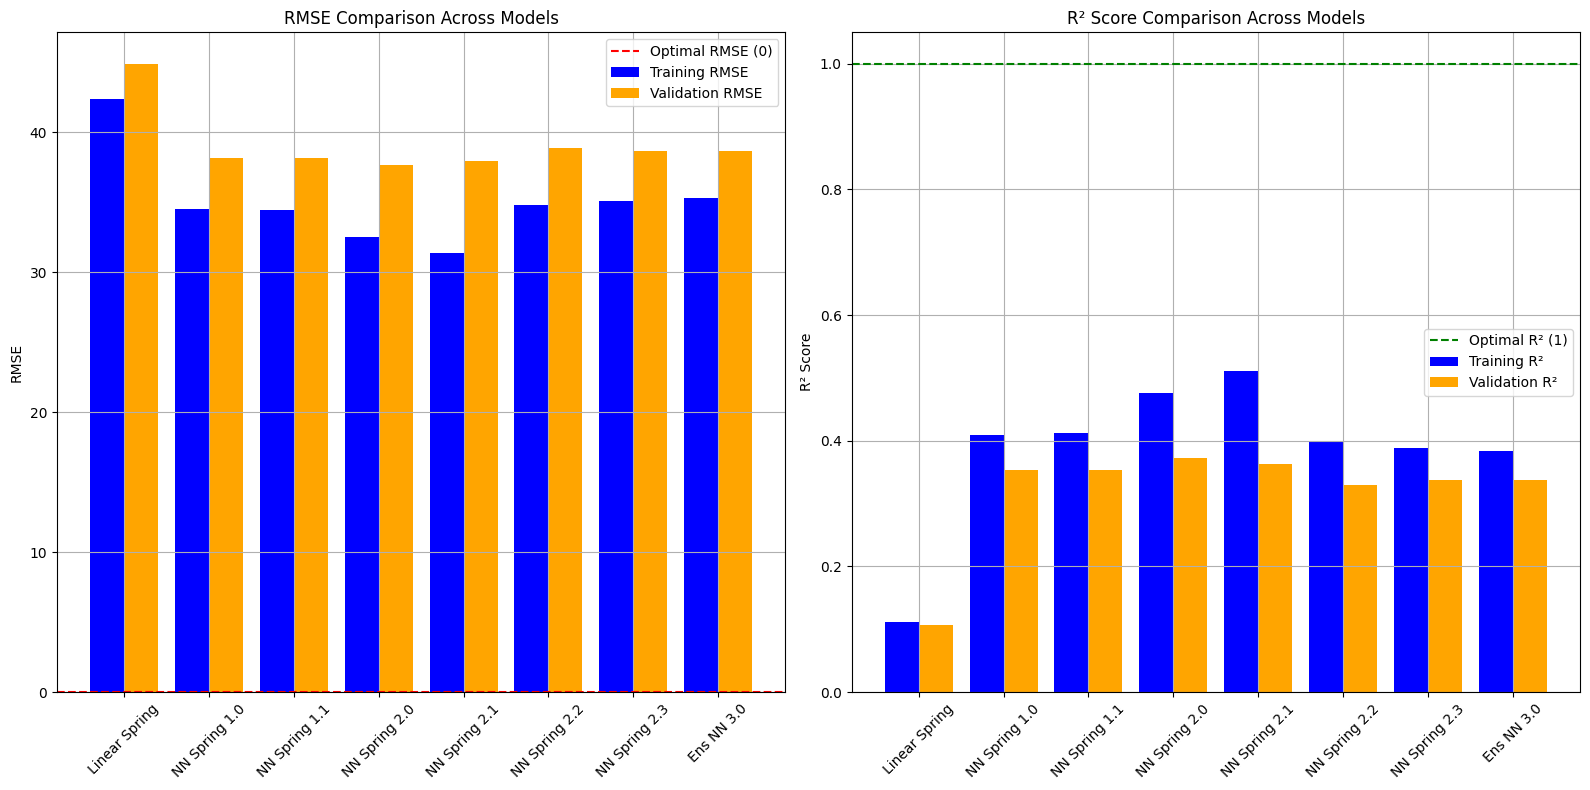

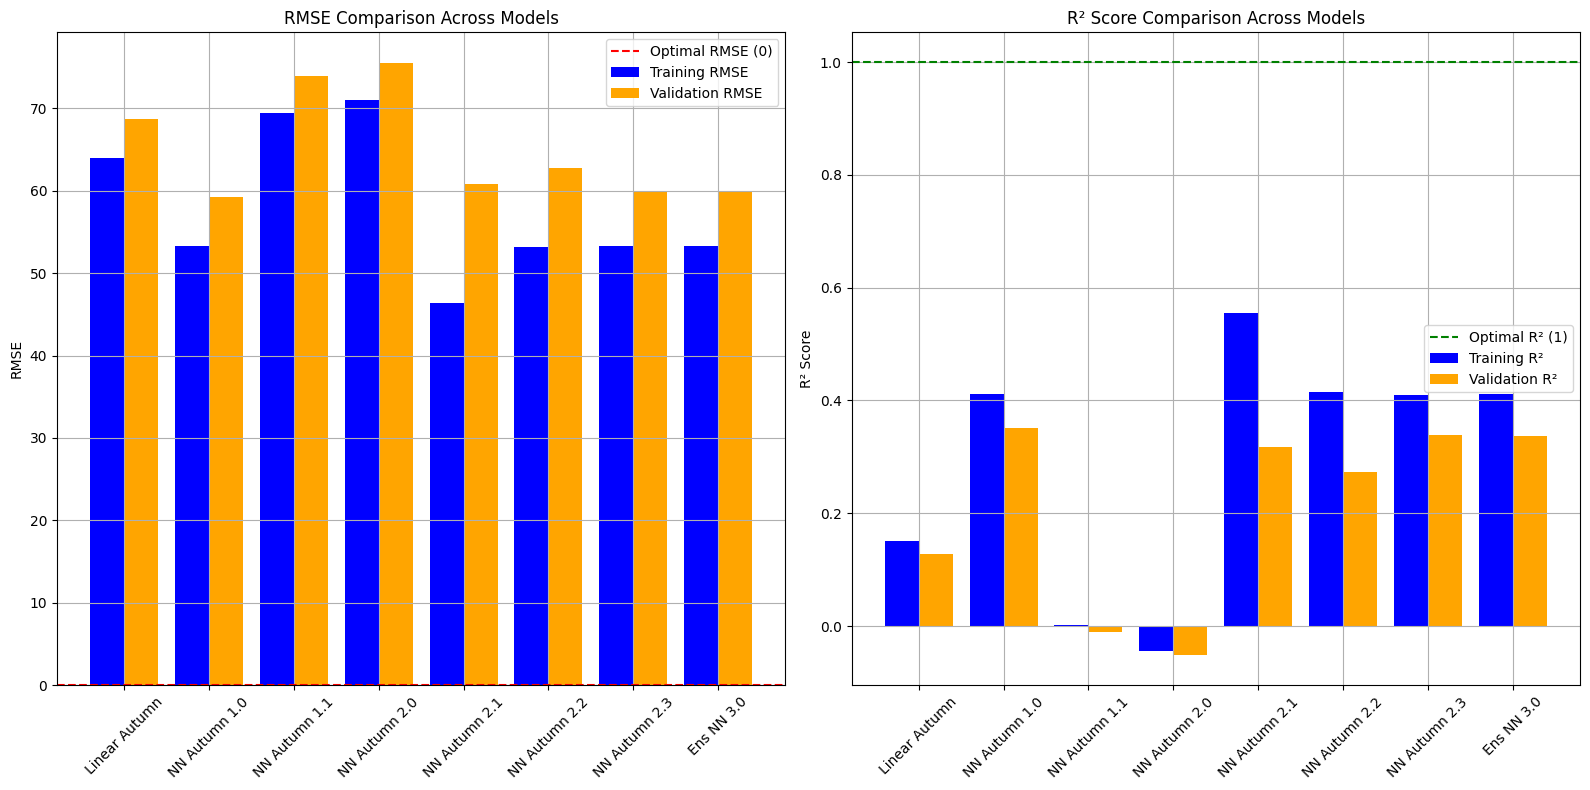

In [115]:
def performanceEvaluation(models, rmse_train, rmse_val, r2_train, r2_val):
    # Plot RMSE Comparison
    plt.figure(figsize=(16, 8))
    
    # RMSE Plot
    plt.subplot(1, 2, 1)
    x = np.arange(len(models))  # Positions for bars
    plt.bar(x - 0.2, rmse_train, width=0.4, label="Training RMSE", color="blue")
    plt.bar(x + 0.2, rmse_val, width=0.4, label="Validation RMSE", color="orange")
    plt.axhline(0, color="red", linestyle="--", label="Optimal RMSE (0)")
    plt.xticks(x, models, rotation=45)
    plt.ylabel("RMSE")
    plt.title("RMSE Comparison Across Models")
    plt.legend()
    plt.grid(True)
    
    # R² Plot
    plt.subplot(1, 2, 2)
    plt.bar(x - 0.2, r2_train, width=0.4, label="Training R²", color="blue")
    plt.bar(x + 0.2, r2_val, width=0.4, label="Validation R²", color="orange")
    plt.axhline(1, color="green", linestyle="--", label="Optimal R² (1)")
    plt.xticks(x, models, rotation=45)
    plt.ylabel("R² Score")
    plt.title("R² Score Comparison Across Models")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
performanceEvaluation(models_spring, rmse_train_spring, rmse_val_spring, r2_train_spring, r2_val_spring)
performanceEvaluation(models_autumn, rmse_train_autumn, rmse_val_autumn, r2_train_autumn, r2_val_autumn)

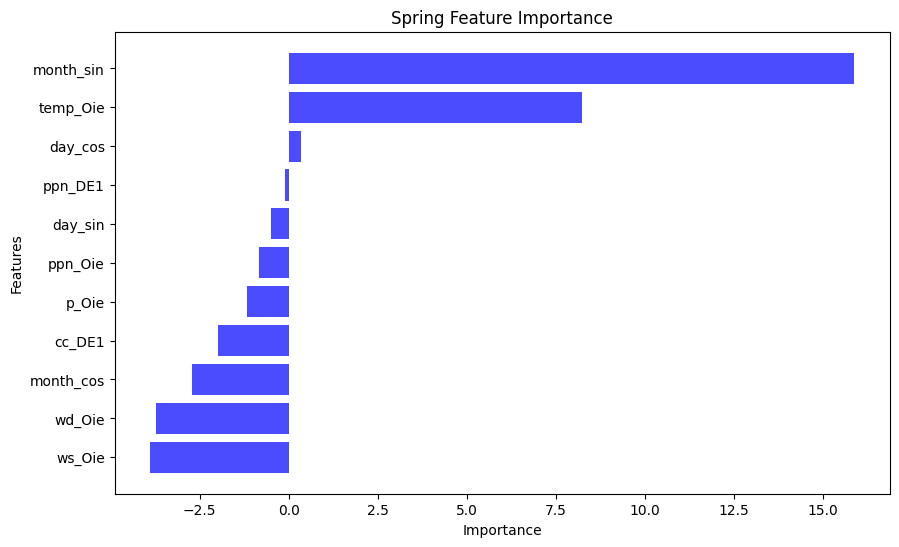

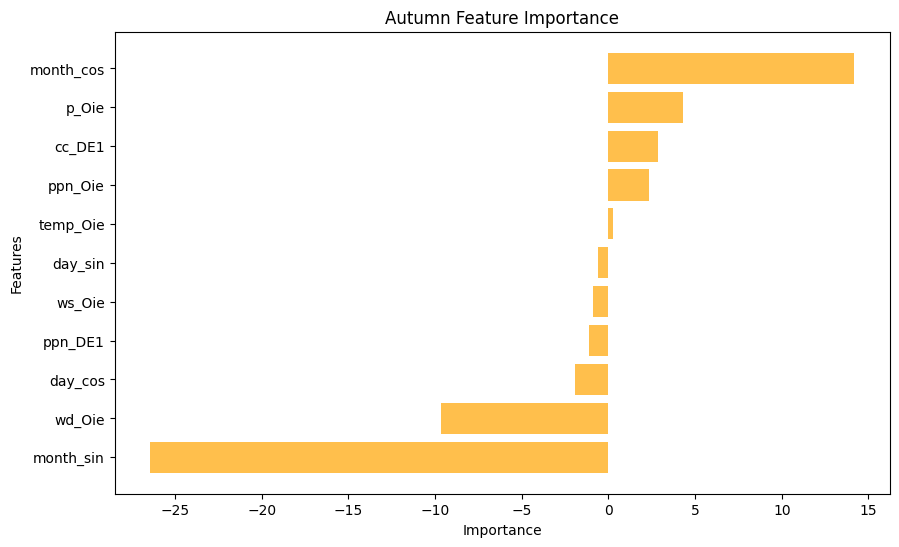

In [116]:
# Feature Importance Analysis using Linear Regression Coefficients
importance_spring = pd.DataFrame({'Feature': predictors, 'Importance': lin_reg_spring.coef_})
importance_spring = importance_spring.sort_values(by='Importance', ascending=False)

importance_autumn = pd.DataFrame({'Feature': predictors, 'Importance': lin_reg_autumn.coef_})
importance_autumn = importance_autumn.sort_values(by='Importance', ascending=False)

# Grafico per Spring
plt.figure(figsize=(10, 6))
plt.barh(importance_spring['Feature'], importance_spring['Importance'], color='blue', alpha=0.7)
plt.title('Spring Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Inverti l'asse y per abbinare lo stile del grafico precedente
plt.show()

# Grafico per Autumn
plt.figure(figsize=(10, 6))
plt.barh(importance_autumn['Feature'], importance_autumn['Importance'], color='orange', alpha=0.7)
plt.title('Autumn Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Inverti l'asse y per abbinare lo stile del grafico precedente
plt.show()

In [117]:
# Feature Importance Analysis for NN 3.0 (based on model 2.3)

# Function to compute gradients for the entire dataset
def compute_dataset_sensitivity(model, X_dataset):
    all_gradients = []
    for sample in X_dataset:  # Iterate over each sample
        with tf.GradientTape() as tape:
            sample = tf.expand_dims(sample, axis=0)  # Add batch dimension
            tape.watch(sample)
            prediction = model(sample)
        gradients = tape.gradient(prediction, sample)
        all_gradients.append(gradients.numpy().flatten())  # Flatten to 1D
    return np.array(all_gradients)
    
# Convert the training data to a TensorFlow tensor
def featureImportance(X_train, model):
    X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
    
    # Calculate sensitivities
    all_sensitivities = compute_dataset_sensitivity(model, X_train_tensor)
    
    # Aggregate sensitivities (mean absolute value for each feature)
    mean_absolute_sensitivity = np.mean(np.abs(all_sensitivities), axis=0)
    
    # Aggregate sensitivities (mean value for each feature)
    mean_sensitivity = np.mean(all_sensitivities, axis=0)
    
    # Extract feature names from the DataFrame for plotting
    feature_names = data[predictors].columns.tolist()
    
    # Plot the average feature sensitivity
    plt.barh(feature_names, mean_absolute_sensitivity)
    plt.title("Average Feature Sensitivity (Training Set)")
    plt.xlabel("Mean Absolute Gradient")
    plt.ylabel("Features")
    plt.show()

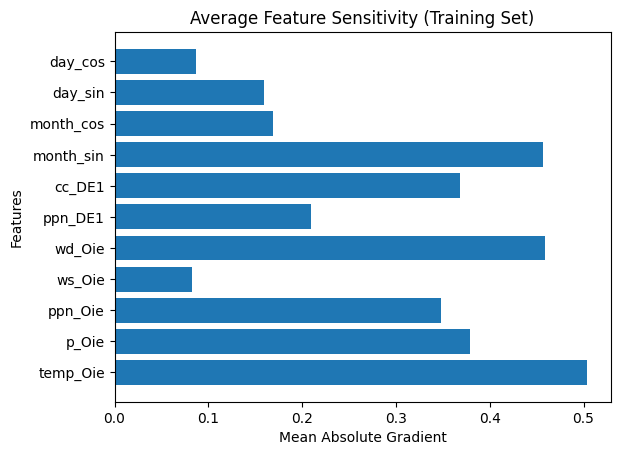

In [118]:
featureImportance(X_train_spring, nn_spring)

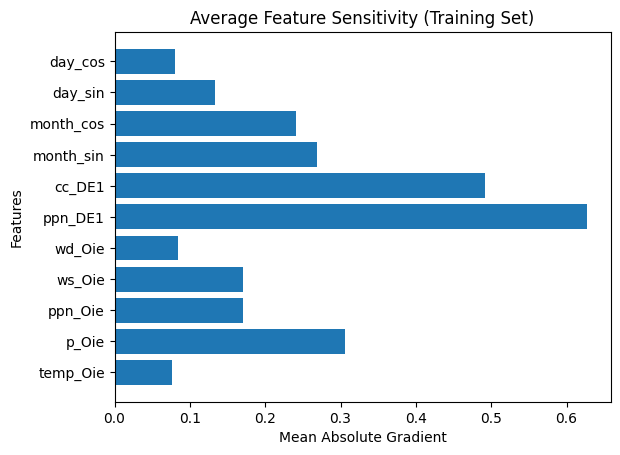

In [119]:
featureImportance(X_train_autumn, nn_autumn)